

#Teste Avaliação de Risco de Credito (Porto Seguro)

## Entendimento do problema de Negócio

Construir um **modelo que preveja a probabilidade de um motorista fazer um sinistro de seguro auto no próximo ano**

**"Sinistro"** é um termo usado no setor de seguros para se referir a um evento em que o segurado sofre um prejuízo coberto pela sua apólice e, consequentemente, faz uma reclamação ou solicitação de indenização à seguradora. No contexto de seguro auto, um sinistro pode envolver situações como:

1. Acidentes de trânsito (colisões, capotagens, etc.);
2. Roubo ou furto do veículo;
3. Danos causados por fenômenos naturais (enchentes, granizo, etc.);
4. Danos causados por terceiros (vandalismo, por exemplo);
5. Entre outros.

Após a ocorrência de um sinistro, o segurado deve entrar em contato com a seguradora para informar o ocorrido e iniciar o processo de avaliação e eventual indenização, conforme estabelecido na apólice de seguro.   

## Entendimento dos Dados

Para este projeto utilizaremos os dados disponibilizados pela seguradora Porto Seguro no ambiente Kaggle:

https://www.kaggle.com/competitions/porto-seguro-safe-driver-prediction/data

Nos dados de treino e teste:
- variáveis que pertencem a agrupamentos similares são marcadas como tal nos nomes das variáveis (por exemplo, ind, reg, car, calc).

- Os nomes das variáveis incluem o sufixo "bin" para indicar variáveis binárias e "cat" para indicar varipaveis categóricas. Variáveis sem essas designações são contínuas ou ordinais.

- Valores de -1 indicam nulo.

- A coluna "target" indica se uma reclamação (sinistro) foi feita ou não para aquele titular da apólice.

O arquivo train.csv contém os dados de treino, onde cada linha corresponde a um titular de apólice, e a coluna "target" indica que uma reclamação foi feita.
O arquivo test.csv contém os dados de teste.


## Data Prep

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import functions as fun

In [0]:
#Importando os dados

df_0 = pd.read_csv('/Volumes/workspace/data_science/medium/porto_seguro/files/train (1).csv')
df_0.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [0]:
df_0.shape

(595212, 59)

- 59 features
- 595212 linhas

In [0]:
df_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

Para predição,iremos pegar os dados de 1 ano atrás para poder prever como o evento irá acontecer em 1 ano, a quantidade de dias para trás que queremos pegar será de acordo com a quantidade de dias para frente que queremos prever.

*EX: Se eu quero prever 6 meses, eu buscaria dados de 6 meses no passado da data presente da analise.*

Mas cuidado quanto mais distante a predição tiver da referencia menos poder preditivo iremos ter, ou seja, fazer uma predição muito longa pode afetar na predição do modelo.

In [0]:

def missing_values_table(df):

  metadados = pd.DataFrame({
      'nome_variavel': df.columns,
      'tipos_de_dados': df.dtypes,
      'numero_de_missing': df.isnull().sum(),
      'percentual_de_missing': df.isnull().sum() * 100 / len(df),
      'unknown': df.isin(['unknown']).sum(),
      'percentual_unknown': df.isin(['unknown']).sum() * 100 / len(df),
      'numero_de_unicos': df.nunique(),
  })

  metadados = metadados.sort_values(by='numero_de_missing', ascending=False).round(1)
  metadados = metadados.reset_index(drop=True)

  return metadados

metadados = missing_values_table(df_0)
metadados.head(21)

,nome_variavel,tipos_de_dados,numero_de_missing,percentual_de_missing,unknown,percentual_unknown,numero_de_unicos
0,id,int64,0,0.0,0,0.0,595212
1,ps_calc_06,int64,0,0.0,0,0.0,11
2,ps_car_10_cat,int64,0,0.0,0,0.0,3
3,ps_car_11_cat,int64,0,0.0,0,0.0,104
4,ps_car_11,int64,0,0.0,0,0.0,5
5,ps_car_12,float64,0,0.0,0,0.0,184
6,ps_car_13,float64,0,0.0,0,0.0,70482
7,ps_car_14,float64,0,0.0,0,0.0,850
8,ps_car_15,float64,0,0.0,0,0.0,15
9,ps_calc_01,float64,0,0.0,0,0.0,10


Podemos verificar que nessa primeira verificação, não temos NaN, entretando ao lermos as informações dos dado, verificamos que o dados nulos estão sinalizados como '-1', então se faz necessário verificar quais features possuem '-1' para fazermos a mudança para Nan

Mas antes de qualquer processo, os dados brutos serão dividido em treino e teste para que futuramente possamos fazer a validação desse projeto antes mesmo de ser feito a aplicação com os dados de teste já enviados no projeto.
Isso ocorre que nessa situação, teremos que fazer o modelo de validação nesse banco de dados teste criado para ai sim, após toda a nossa analise e verificação do melhor modelo, a gente aplicar no modelo de teste enviado pela competição.

In [0]:
#Separando dados em treino e teste
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_0,test_size = 0.3, random_state = 42)
train.shape, test.shape

((416648, 59), (178564, 59))

In [0]:
df_train_01 = train.copy()
df_test_01 = test.copy()

In [0]:
#Substituindo valor -1 por nan

df_train_01.replace(-1, np.nan,inplace=True)

metadados = missing_values_table(df_train_01)
metadados.head(21)

,nome_variavel,tipos_de_dados,numero_de_missing,percentual_de_missing,unknown,percentual_unknown,numero_de_unicos
0,ps_car_03_cat,float64,287957,69.1,0,0.0,2
1,ps_car_05_cat,float64,186779,44.8,0,0.0,2
2,ps_reg_03,float64,75228,18.1,0,0.0,4965
3,ps_car_14,float64,29746,7.1,0,0.0,831
4,ps_car_07_cat,float64,8018,1.9,0,0.0,2
5,ps_ind_05_cat,float64,4057,1.0,0,0.0,7
6,ps_car_09_cat,float64,393,0.1,0,0.0,5
7,ps_ind_02_cat,float64,139,0.0,0,0.0,4
8,ps_car_01_cat,float64,69,0.0,0,0.0,12
9,ps_ind_04_cat,float64,55,0.0,0,0.0,2


Agora podemos verificar que existe um alta porcentagem de valores nulos em algumas features. Como isso se faz necessário fazer um filtro para a exclusão de features que possuem alta porcentagem de nulos para evitar que esses comprometam os modelos.

### Excluindo features

In [0]:
missing_cutoff = 68

drop_vars_nulos = metadados[(metadados['percentual_de_missing'] >= missing_cutoff)]
lista_drop_vars = list(drop_vars_nulos.nome_variavel.values)

print('Variáveis que serão excluídas por alto percentual de nulos: ',lista_drop_vars)

# retirando lista de variáveis com alto percentual de nulos
df_train_02 = df_train_01.drop(axis=1,columns=lista_drop_vars)
df_train_02.shape

Variáveis que serão excluídas por alto percentual de nulos:  ['ps_car_03_cat']


(416648, 58)

In [0]:
# Salvando arquivo
import pickle

with open('/Volumes/workspace/data_science/medium/porto_seguro/dataprep/prd_drop_nullvars.pkl', 'wb') as f:
    pickle.dump(lista_drop_vars, f)

In [0]:
with open('/Volumes/workspace/data_science/medium/porto_seguro/dataprep/prd_drop_nullvars.pkl', 'rb') as f:
  loaded_drop = pickle.load(f)
loaded_drop
#Aplicando no test
test_prod = test.copy()
test_prod = test_prod.drop(axis=1,columns=loaded_drop)
test_prod.shape

(178564, 58)

Como foi verificado na tabela acima ainda tem features com valores nulos, sendo assim necessário a sua substituição.
Para o processo de substiuição existem diversos metodos que podem ser utilizados para isso, como:

*   Imputação simples: substituir por média, mediana ou moda.

*   Valor constante: usar um valor fixo (ex.: 0, -1, "desconhecido").

*   Imputação por grupo: preencher com estatísticas dentro de um grupo (ex.: média por categoria).

*   Forward / Backward fill: propagar valores anteriores ou posteriores (comum em séries temporais).

*   Model-based imputation: prever o valor ausente com modelos (KNN, regressão, árvores).

*   Múltipla imputação: gerar diferentes valores possíveis para reduzir viés estatístico.






Importante saliente que as médias encontradas no banco de dados de treino, devem ser aplicadas no banco de dados de teste, não podemos fazer os dois bancos de dados independentes pois assim teremos um data leaking e o modelo não conseguirá fazer a verificação real do sistema (corrigir o texto)

Para evitar que os valores do target e id sejam modificados, essas features serão retiradas temporariamente para que a limpeza seja realiazada da maneira adequada, você perceberá que esse processo será realizado com uma certa frequencia durante os processos de dataprep e feature selection

In [0]:
df_train_02 = df_train_02.drop(axis=1, columns=['id', 'target'])
df_train_02.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
391389,7,1.0,9,1.0,0.0,0,0,1,0,0,0,0,0,0,10,1,0,0,0.9,1.6,1.692262,11.0,0.0,1,1.0,17,NaN,1,2.0,1,104,2.0,0.447214,1.550513,0.415812,3.316625,0.7,0.9,0.2,1,3,9,3,10,2,7,5,2,4,10,0,1,1,0,0,1
518243,5,1.0,3,1.0,0.0,0,1,0,0,0,0,0,0,0,9,1,0,0,0.5,0.5,0.803508,6.0,1.0,0,1.0,1,1.0,1,0.0,1,85,3.0,0.374166,0.698345,0.397492,2.645751,0.9,0.7,0.8,3,3,7,5,9,3,5,3,1,6,12,0,1,1,0,1,0
136933,0,1.0,6,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0.9,1.4,1.229583,6.0,1.0,0,1.0,5,1.0,1,0.0,1,104,3.0,0.399750,0.568782,0.393065,1.732051,0.8,0.2,0.8,1,2,8,5,9,2,14,4,3,4,10,0,0,1,0,1,0
432345,0,1.0,4,1.0,0.0,1,0,0,0,0,0,0,0,0,6,0,0,1,0.1,0.1,NaN,7.0,1.0,0,NaN,1,1.0,1,2.0,1,40,2.0,0.374166,0.770210,0.381445,3.464102,0.1,0.0,0.8,4,2,7,1,10,2,9,5,3,4,8,0,0,1,0,1,0
127021,1,1.0,2,0.0,0.0,0,0,0,1,0,0,0,0,0,6,0,1,0,0.9,0.5,0.761577,7.0,1.0,0,0.0,4,0.0,1,2.0,1,12,3.0,0.400000,0.830115,0.324808,3.464102,0.8,0.4,0.9,2,3,8,3,8,4,4,8,1,4,5,0,1,1,1,1,0


In [0]:
def pod_custom_fillna(df):
    import pandas as pd
    import numpy as np

    # Substituindo -1 por nulos
    # Esta função serve para este modelo ou caso específico, porque pode ser que em outras situações o missing não venha marcado com -1

    df.replace(-1, np.nan, inplace=True)
    numerical_cols = df.select_dtypes(include=['float64', 'float32', 'int64', 'int32']).columns
    means = {}

    for col in numerical_cols:
        means[col] = df[col].mean()
        df[col].fillna(means[col], inplace=True)

    categorical_cols = df.select_dtypes(include=['object']).columns
    df[categorical_cols] = df[categorical_cols].fillna('POD_VERIFICAR')

    return df, means


In [0]:
df_train_03, means = fun_custom_fillna(df_train_02)

In [0]:
# Salvando as médias encontradas em cada feature no banco de dados de treino

with open('/Volumes/workspace/data_science/medium/porto_seguro/dataprep/prd_fillna.pkl', 'wb') as f:
  pickle.dump(means, f)

In [0]:
with open('/Volumes/workspace/data_science/medium/porto_seguro/dataprep/prd_fillna.pkl', 'rb') as f:
  loaded_means = pickle.load(f)
loaded_means

{'ps_ind_01': 1.902154816535781,
 'ps_ind_02_cat': 1.359569661159783,
 'ps_ind_03': 4.4241902037211265,
 'ps_ind_04_cat': 0.4168841051097834,
 'ps_ind_05_cat': 0.41899605178009214,
 'ps_ind_06_bin': 0.39382644342466544,
 'ps_ind_07_bin': 0.2568019047253317,
 'ps_ind_08_bin': 0.16375453620322192,
 'ps_ind_09_bin': 0.185617115646781,
 'ps_ind_10_bin': 0.0003672164512970181,
 'ps_ind_11_bin': 0.0016608744071734413,
 'ps_ind_12_bin': 0.009283615905992589,
 'ps_ind_13_bin': 0.0009048405368560511,
 'ps_ind_14': 0.0122165473013191,
 'ps_ind_15': 7.298587776732398,
 'ps_ind_16_bin': 0.6603967857760028,
 'ps_ind_17_bin': 0.1215630460244619,
 'ps_ind_18_bin': 0.15339567212611124,
 'ps_reg_01': 0.6111741806032911,
 'ps_reg_02': 0.43951201013805413,
 'ps_reg_03': 0.8943857761820005,
 'ps_car_01_cat': 8.297888275693206,
 'ps_car_02_cat': 0.8304171886925592,
 'ps_car_04_cat': 0.7271941782991878,
 'ps_car_05_cat': 0.5257559740547877,
 'ps_car_06_cat': 6.554612046619688,
 'ps_car_07_cat': 0.9478403445

In [0]:
# Aplicando as médias encontradas no banco de dados do test

def custom_fillna_prod(df, means):
    import numpy as np
    import pandas as pd
    df.replace(-1, np.nan, inplace=True)
    for col, mean_value in means.items():
      df[col] = df[col].fillna(mean_value)

    categorical_cols = df.select_dtypes(include=['object']).columns
    df[categorical_cols] = df[categorical_cols].fillna('POD_VERIFICAR')
    return df

In [0]:
#Aplicando no banco de dados de teste
test_prod = test_prod.drop(axis=1, columns=['id', 'target'])
custom_fillna_prod(test_prod, loaded_means)
test_prod.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
256886,4,1.0,5,1.0,0.0,1,0,0,0,0,0,0,0,0,8,0,1,0,0.7,1.4,1.368393,10.0,1.0,0,1.000000,11,1.0,1,0.0,1,16,3.0,0.421782,0.596720,0.373497,1.414214,0.0,0.3,0.2,5,0,8,3,9,3,7,7,3,2,3,0,1,0,1,0,0
118785,6,2.0,10,1.0,0.0,0,0,0,1,0,0,0,0,0,5,1,0,0,0.9,1.4,1.798437,10.0,0.0,0,1.000000,5,1.0,1,0.0,1,104,1.0,0.424264,1.237825,0.446094,3.162278,0.3,0.8,0.3,1,1,8,4,8,4,9,6,3,3,5,0,1,1,0,0,0
56083,4,1.0,9,1.0,0.0,0,0,1,0,0,0,0,0,0,10,0,0,0,0.1,0.1,0.894386,11.0,1.0,0,1.000000,1,1.0,1,1.0,1,31,3.0,0.400000,0.546628,0.374724,1.000000,0.2,0.6,0.3,5,1,8,2,8,2,12,3,1,0,7,0,0,1,0,0,0
542002,0,1.0,7,1.0,4.0,0,1,0,0,0,0,0,0,0,3,0,0,1,0.9,1.3,0.868907,11.0,1.0,0,1.000000,15,1.0,0,2.0,1,97,3.0,0.360555,0.874147,0.298329,3.605551,0.4,0.8,0.1,3,2,7,4,10,2,5,1,1,3,6,1,1,0,0,0,0
349518,1,1.0,3,1.0,0.0,1,0,0,0,0,0,0,0,0,12,0,1,0,0.6,0.4,0.741620,11.0,1.0,0,0.525756,1,1.0,1,2.0,1,38,3.0,0.316228,0.740165,0.359861,3.464102,0.0,0.8,0.9,3,2,10,3,11,3,10,6,1,5,6,0,1,0,0,0,0


In [0]:
df_train_03.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
391389,7,1.0,9,1.0,0.0,0,0,1,0,0,0,0,0,0,10,1,0,0,0.9,1.6,1.692262,11.0,0.0,1,1.000000,17,0.94784,1,2.0,1,104,2.0,0.447214,1.550513,0.415812,3.316625,0.7,0.9,0.2,1,3,9,3,10,2,7,5,2,4,10,0,1,1,0,0,1
518243,5,1.0,3,1.0,0.0,0,1,0,0,0,0,0,0,0,9,1,0,0,0.5,0.5,0.803508,6.0,1.0,0,1.000000,1,1.00000,1,0.0,1,85,3.0,0.374166,0.698345,0.397492,2.645751,0.9,0.7,0.8,3,3,7,5,9,3,5,3,1,6,12,0,1,1,0,1,0
136933,0,1.0,6,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0.9,1.4,1.229583,6.0,1.0,0,1.000000,5,1.00000,1,0.0,1,104,3.0,0.399750,0.568782,0.393065,1.732051,0.8,0.2,0.8,1,2,8,5,9,2,14,4,3,4,10,0,0,1,0,1,0
432345,0,1.0,4,1.0,0.0,1,0,0,0,0,0,0,0,0,6,0,0,1,0.1,0.1,0.894386,7.0,1.0,0,0.525756,1,1.00000,1,2.0,1,40,2.0,0.374166,0.770210,0.381445,3.464102,0.1,0.0,0.8,4,2,7,1,10,2,9,5,3,4,8,0,0,1,0,1,0
127021,1,1.0,2,0.0,0.0,0,0,0,1,0,0,0,0,0,6,0,1,0,0.9,0.5,0.761577,7.0,1.0,0,0.000000,4,0.00000,1,2.0,1,12,3.0,0.400000,0.830115,0.324808,3.464102,0.8,0.4,0.9,2,3,8,3,8,4,4,8,1,4,5,0,1,1,1,1,0


### Padronização

Esse processo é necessário em cenários de alta cardinalidade para evitar que modelos sensíveis à escala interpretem valores numéricos maiores como mais relevantes. A padronização coloca as variáveis na mesma escala, reduzindo viés, melhorando a convergência do modelo e garantindo que nenhuma feature domine o aprendizado apenas por sua magnitude.

In [0]:
from sklearn.preprocessing import StandardScaler

# Instanciando o scaler
scaler = StandardScaler()

# Padronizando a base de treino
df_train_03_scaled = scaler.fit_transform(df_train_03)
df_train_04 = pd.DataFrame(df_train_03_scaled, columns=df_train_03.columns, index=df_train_03.index)

# Salva o scaler em um arquivo .pkl
with open('/Volumes/workspace/data_science/medium/porto_seguro/dataprep/prd_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [0]:
df_train_04.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
391389,2.568989,-0.542601,1.695565,1.182765,-0.31183,-0.806035,-0.587823,2.259801,-0.477413,-0.019166,-0.040788,-0.096802,-0.030094,-0.096715,0.761809,0.717106,-0.372002,-0.425663,1.004300,2.869279,2.551830e+00,1.078877,-2.212882,0.126422,1.278655,1.898582,-1.008381e-15,0.447962,0.684547,0.085789,1.265515,-0.416020,1.154184,3.282777,0.933695,0.343775,0.870596,1.570820,-0.869620,-1.228645,0.980982,0.980676,-0.004784,0.530273,-0.271036,-0.493106,-0.189128,0.464250,0.665396,0.896386,-0.373426,0.770766,0.897048,-0.634586,-0.730772,2.350925
518243,1.561116,-0.542601,-0.527733,1.182765,-0.31183,-0.806035,1.701191,-0.442517,-0.477413,-0.019166,-0.040788,-0.096802,-0.030094,-0.096715,0.479805,0.717106,-0.372002,-0.425663,-0.386573,0.149555,-2.906527e-01,-0.917482,0.451902,-0.336992,1.278655,-1.009621,2.368750e-01,0.447962,-1.364444,0.085789,0.689777,0.785796,-0.098729,-0.510640,0.517388,-0.573194,1.567305,0.873885,1.220110,0.562016,0.980982,-0.517373,1.408842,-0.155088,0.530926,-1.182005,-1.045842,-0.367316,1.845816,1.624615,-0.373426,0.770766,0.897048,-0.634586,1.368416,-0.425364
136933,-0.958565,-0.542601,0.583916,1.182765,-0.31183,1.240641,-0.587823,-0.442517,-0.477413,-0.019166,-0.040788,-0.096802,-0.030094,-0.096715,-2.058230,-1.394494,-0.372002,2.349274,1.004300,2.374783,1.072055e+00,-0.917482,0.451902,-0.336992,1.278655,-0.282570,2.368750e-01,0.447962,-1.364444,0.085789,1.265515,0.785796,0.340090,-1.087392,0.416784,-1.822067,1.218950,-0.868451,1.220110,-1.228645,0.099989,0.231651,1.408842,-0.155088,-0.271036,1.918039,-0.617485,1.295816,0.665396,0.896386,-0.373426,-1.297410,0.897048,-0.634586,1.368416,-0.425364
432345,-0.958565,-0.542601,-0.157184,1.182765,-0.31183,1.240641,-0.587823,-0.442517,-0.477413,-0.019166,-0.040788,-0.096802,-0.030094,-0.096715,-0.366207,-1.394494,-0.372002,2.349274,-1.777446,-0.839435,-3.550803e-16,-0.518210,0.451902,-0.336992,0.000000,-1.009621,2.368750e-01,0.447962,0.684547,0.085789,-0.673815,-0.416020,-0.098729,-0.190735,0.152728,0.545350,-1.219531,-1.565385,1.220110,1.457347,0.099989,-0.517373,-1.418410,0.530273,-0.271036,0.195793,-0.189128,1.295816,0.665396,0.168156,-0.373426,-1.297410,0.897048,-0.634586,1.368416,-0.425364
127021,-0.454629,-0.542601,-0.898283,-0.845588,-0.31183,-0.806035,-0.587823,-0.442517,2.094620,-0.019166,-0.040788,-0.096802,-0.030094,-0.096715,-0.366207,-1.394494,2.688156,-0.425663,1.004300,0.149555,-4.247585e-01,-0.518210,0.451902,-0.336992,-1.417541,-0.464333,-4.304471e+00,0.447962,0.684547,0.085789,-1.522272,0.785796,0.344379,0.075932,-1.134278,0.545350,1.218950,-0.171516,1.568398,-0.333314,0.980982,0.231651,-0.004784,-0.840450,1.332888,-1.526454,1.095943,-0.367316,0.665396,-0.924188,-0.373426,0.770766,0.897048,1.575831,1.368416,-0.425364


In [0]:
# Carregar o scaler
with open('/Volumes/workspace/data_science/medium/porto_seguro/dataprep/prd_scaler.pkl', 'rb') as f:
    loaded_scaler = pickle.load(f)

# Aplicando no banco de dados de Teste

test_df_scaled = loaded_scaler.transform(test_prod)
test_df = pd.DataFrame(test_df_scaled, columns=test_prod.columns, index=test_prod.index)
test_df.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
256886,1.057180,-0.542601,0.213366,1.182765,-0.311830,1.240641,-0.587823,-0.442517,-0.477413,-0.019166,-0.040788,-0.096802,-0.030094,-0.096715,0.197801,-1.394494,2.688156,-0.425663,0.308864,2.374783,1.516008e+00,0.679605,0.451902,-0.336992,1.278655,0.808006,0.236875,0.447962,-1.364444,0.085789,-1.401063,0.785796,0.717982,-0.963025,-2.787195e-02,-2.256496,-1.567885,-0.519983,-0.869620,2.352677,-1.661996,0.231651,-0.004784,-0.155088,0.530926,-0.493106,0.667586,1.295816,-0.515024,-1.652418,-0.373426,0.770766,-1.114768,1.575831,-0.730772,-0.425364
118785,2.065053,0.966428,2.066114,1.182765,-0.311830,-0.806035,-0.587823,-0.442517,2.094620,-0.019166,-0.040788,-0.096802,-0.030094,-0.096715,-0.648211,0.717106,-0.372002,-0.425663,1.004300,2.374783,2.891407e+00,0.679605,-2.212882,-0.336992,1.278655,-0.282570,0.236875,0.447962,-1.364444,0.085789,1.265515,-1.617837,0.760555,1.890850,1.621810e+00,0.132809,-0.522822,1.222352,-0.521332,-1.228645,-0.781003,0.231651,0.702029,-0.840450,1.332888,0.195793,0.239229,1.295816,0.075186,-0.924188,-0.373426,0.770766,0.897048,-0.634586,-0.730772,-0.425364
56083,1.057180,-0.542601,1.695565,1.182765,-0.311830,-0.806035,-0.587823,2.259801,-0.477413,-0.019166,-0.040788,-0.096802,-0.030094,-0.096715,0.761809,-1.394494,-0.372002,-0.425663,-1.777446,-0.839435,-3.550803e-16,1.078877,0.451902,-0.336992,1.278655,-1.009621,0.236875,0.447962,-0.339949,0.085789,-0.946533,0.785796,0.344379,-1.186010,3.784268e-15,-2.822655,-0.871176,0.525418,-0.521332,2.352677,-0.781003,0.231651,-0.711597,-0.840450,-0.271036,1.229141,-1.045842,-0.367316,-1.695444,-0.195959,-0.373426,-1.297410,0.897048,-0.634586,-0.730772,-0.425364
542002,-0.958565,-0.542601,0.954465,1.182765,2.665092,-0.806035,1.701191,-0.442517,-0.477413,-0.019166,-0.040788,-0.096802,-0.030094,-0.096715,-1.212218,-1.394494,-0.372002,2.349274,1.004300,2.127536,-8.148708e-02,1.078877,0.451902,-0.336992,1.278655,1.535056,0.236875,-2.232334,0.684547,0.085789,1.053401,0.785796,-0.332178,0.271939,-1.735980e+00,0.738688,-0.174467,1.222352,-1.217908,0.562016,0.099989,-0.517373,0.702029,0.530273,-0.271036,-1.182005,-1.902556,-0.367316,0.075186,-0.560074,2.677904,0.770766,-1.114768,-0.634586,-0.730772,-0.425364
349518,-0.454629,-0.542601,-0.527733,1.182765,-0.311830,1.240641,-0.587823,-0.442517,-0.477413,-0.019166,-0.040788,-0.096802,-0.030094,-0.096715,1.325816,-1.394494,2.688156,-0.425663,-0.038855,-0.097692,-4.885880e-01,1.078877,0.451902,-0.336992,0.000000,-1.009621,0.236875,0.447962,0.684547,0.085789,-0.734419,0.785796,-1.092479,-0.324480,-3.377311e-01,0.545350,-1.567885,1.222352,1.568398,0.562016,0.099989,1.729701,-0.004784,1.215634,0.530926,0.540242,0.239229,-0.367316,1.255606,-0.560074,-0.373426,0.770766,-1.114768,-0.634586,-0.730772,-0.425364


In [0]:
# Trazer o target e id para a tabela pós dataprep

abt_train = df_train_04.merge(train[['id','target']], left_index=True, right_index=True, how='inner')
abt_test = test_df.merge(test[['id','target']], left_index=True, right_index=True, how='inner')

In [0]:
#Criando arquivos CSV

abt_train.to_csv('/Volumes/workspace/data_science/medium/porto_seguro/arquivos/abt_train.csv')
abt_test.to_csv('/Volumes/workspace/data_science/medium/porto_seguro/arquivos/abt_test.csv')

Se faz necessário a criação desses novos arquivos em csv, devido a se caso seja necessário utilizar os dados de dataprep novamente,os arquivos lidos serão aqueles que já sofreram todo o processo, não sendo necessário realizar toda a preparação novamente.

## Feature Selection

Essa étapa do processo também é de suma imoprtancia, é nela que iremos filtrar as features necessárias para os modelos, é nessa etapa que iremos diminuir o numero de colunas deixando apenas aquelas que mais influênciam no target

In [0]:
abt_train_0 = pd.read_csv('/Volumes/workspace/data_science/medium/porto_seguro/arquivos/abt_train.csv')
abt_test_0 = pd.read_csv('/Volumes/workspace/data_science/medium/porto_seguro/arquivos/abt_test.csv')

abt_train_0.head()


,Unnamed: 0,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,id,target
0,391389,2.568989,-0.542601,1.695565,1.182765,-0.31183,-0.806035,-0.587823,2.259801,-0.477413,-0.019166,-0.040788,-0.096802,-0.030094,-0.096715,0.761809,0.717106,-0.372002,-0.425663,1.004300,2.869279,2.551830e+00,1.078877,-2.212882,0.126422,1.278655,1.898582,-1.008381e-15,0.447962,0.684547,0.085789,1.265515,-0.416020,1.154184,3.282777,0.933695,0.343775,0.870596,1.570820,-0.869620,-1.228645,0.980982,0.980676,-0.004784,0.530273,-0.271036,-0.493106,-0.189128,0.464250,0.665396,0.896386,-0.373426,0.770766,0.897048,-0.634586,-0.730772,2.350925,977816,0
1,518243,1.561116,-0.542601,-0.527733,1.182765,-0.31183,-0.806035,1.701191,-0.442517,-0.477413,-0.019166,-0.040788,-0.096802,-0.030094,-0.096715,0.479805,0.717106,-0.372002,-0.425663,-0.386573,0.149555,-2.906527e-01,-0.917482,0.451902,-0.336992,1.278655,-1.009621,2.368750e-01,0.447962,-1.364444,0.085789,0.689777,0.785796,-0.098729,-0.510640,0.517388,-0.573194,1.567305,0.873885,1.220110,0.562016,0.980982,-0.517373,1.408842,-0.155088,0.530926,-1.182005,-1.045842,-0.367316,1.845816,1.624615,-0.373426,0.770766,0.897048,-0.634586,1.368416,-0.425364,1294939,0
2,136933,-0.958565,-0.542601,0.583916,1.182765,-0.31183,1.240641,-0.587823,-0.442517,-0.477413,-0.019166,-0.040788,-0.096802,-0.030094,-0.096715,-2.058230,-1.394494,-0.372002,2.349274,1.004300,2.374783,1.072055e+00,-0.917482,0.451902,-0.336992,1.278655,-0.282570,2.368750e-01,0.447962,-1.364444,0.085789,1.265515,0.785796,0.340090,-1.087392,0.416784,-1.822067,1.218950,-0.868451,1.220110,-1.228645,0.099989,0.231651,1.408842,-0.155088,-0.271036,1.918039,-0.617485,1.295816,0.665396,0.896386,-0.373426,-1.297410,0.897048,-0.634586,1.368416,-0.425364,342083,0
3,432345,-0.958565,-0.542601,-0.157184,1.182765,-0.31183,1.240641,-0.587823,-0.442517,-0.477413,-0.019166,-0.040788,-0.096802,-0.030094,-0.096715,-0.366207,-1.394494,-0.372002,2.349274,-1.777446,-0.839435,-3.550803e-16,-0.518210,0.451902,-0.336992,0.000000,-1.009621,2.368750e-01,0.447962,0.684547,0.085789,-0.673815,-0.416020,-0.098729,-0.190735,0.152728,0.545350,-1.219531,-1.565385,1.220110,1.457347,0.099989,-0.517373,-1.418410,0.530273,-0.271036,0.195793,-0.189128,1.295816,0.665396,0.168156,-0.373426,-1.297410,0.897048,-0.634586,1.368416,-0.425364,1080386,0
4,127021,-0.454629,-0.542601,-0.898283,-0.845588,-0.31183,-0.806035,-0.587823,-0.442517,2.094620,-0.019166,-0.040788,-0.096802,-0.030094,-0.096715,-0.366207,-1.394494,2.688156,-0.425663,1.004300,0.149555,-4.247585e-01,-0.518210,0.451902,-0.336992,-1.417541,-0.464333,-4.304471e+00,0.447962,0.684547,0.085789,-1.522272,0.785796,0.344379,0.075932,-1.134278,0.545350,1.218950,-0.171516,1.568398,-0.333314,0.980982,0.231651,-0.004784,-0.840450,1.332888,-1.526454,1.095943,-0.367316,0.665396,-0.924188,-0.373426,0.770766,0.897048,1.575831,1.368416,-0.425364,317567,1


Como a feature 'id' é apenas coluna de informação e não deve ter alguma influencia no target  novamente será necessário a sua retirada para que no final do processo eles possam voltar. Também após a verificação do banco de dados, foi visto que uma feature 'Unnamed: 0' apareceu, sendo necessário excluir esta tbm

In [0]:
abt_train_0.drop(axis=1,columns=['Unnamed: 0','id'],inplace=True)
abt_test_0.drop(axis=1,columns=['Unnamed: 0','id'],inplace=True)

print(abt_train_0.shape)
print(abt_test_0.shape)

(416648, 57)
(178564, 57)


In [0]:
# Treinando o MOdelo com o algoritmo de random forest
from sklearn.ensemble import RandomForestClassifier

X = abt_train_0.drop(axis=1,columns='target')
y = abt_train_0.target

clf = RandomForestClassifier()
clf.fit(X, y)

RandomForestClassifier()

Para o corte das features, se dado um valor limite de 50% de influenci, onde features abaixo desse valor serão excluidas.

Número de features selecionadas:  14


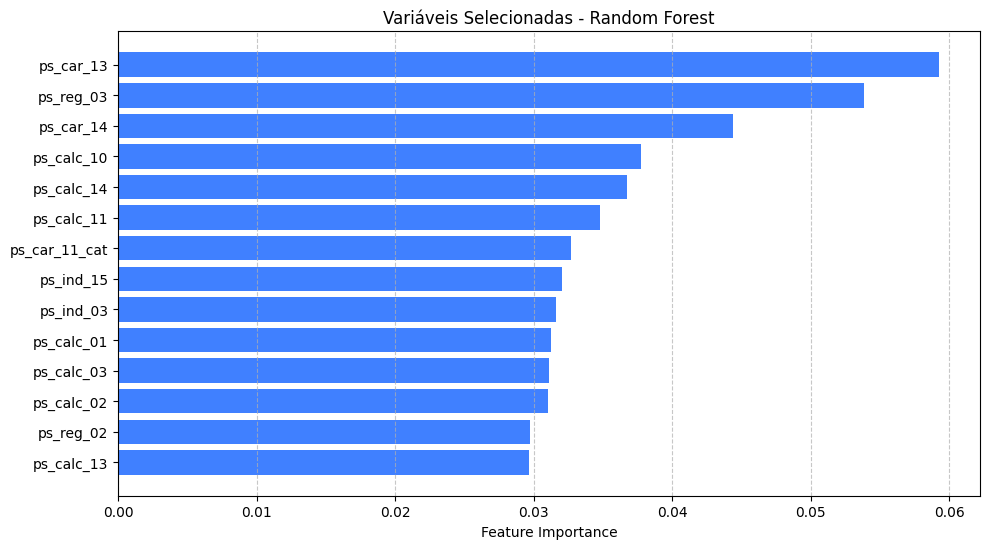

In [0]:
# Obter importância das variáveis
feature_importances = clf.feature_importances_
features = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Ordenar variáveis por importância
features = features.sort_values(by='Importance', ascending=False)

# Estabelecer um limite de corte, por exemplo, x% da importância máxima
cutoff_maximp = 0.5

cutoff = cutoff_maximp * feature_importances.max()

# Selecionar variáveis acima do corte
selected_features = X.columns[feature_importances > cutoff].tolist()
print('Número de features selecionadas: ',len(selected_features))

# Ordenar variáveis por importância
features = features.sort_values(by='Importance', ascending=True)

# Filtrar o DataFrame para apenas as features acima do corte
selected_features_df = features[features['Importance'] > cutoff]

# Ajusta o tamanho da figura com base no número de features selecionadas
plt.figure(figsize=(10, len(selected_features_df)*0.4))

# Plota as features selecionadas
plt.barh(selected_features_df['Feature'], selected_features_df['Importance'], color=(0.25, 0.5, 1))
plt.xlabel("Feature Importance")
plt.title("Variáveis Selecionadas - Random Forest")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [0]:
import pickle
with open('/Volumes/workspace/data_science/medium/porto_seguro/feat_selec/prd_list_features.pkl', 'wb') as f:
    pickle.dump(selected_features, f)

In [0]:
with open('/Volumes/workspace/data_science/medium/porto_seguro/feat_selec/prd_list_features.pkl', 'rb') as f:
    loaded_lista = pickle.load(f)

print(loaded_lista)

['ps_ind_03', 'ps_ind_15', 'ps_reg_02', 'ps_reg_03', 'ps_car_11_cat', 'ps_car_13', 'ps_car_14', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_10', 'ps_calc_11', 'ps_calc_13', 'ps_calc_14']


In [0]:
lista_features = loaded_lista + ['target']
abt_train_01 = abt_train_0[lista_features]

abt_train_01.head()

,ps_ind_03,ps_ind_15,ps_reg_02,ps_reg_03,ps_car_11_cat,ps_car_13,ps_car_14,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_10,ps_calc_11,ps_calc_13,ps_calc_14,target
0,1.695565,0.761809,2.869279,2.551830e+00,1.265515,3.282777,0.933695,0.870596,1.570820,-0.869620,-0.493106,-0.189128,0.665396,0.896386,0
1,-0.527733,0.479805,0.149555,-2.906527e-01,0.689777,-0.510640,0.517388,1.567305,0.873885,1.220110,-1.182005,-1.045842,1.845816,1.624615,0
2,0.583916,-2.058230,2.374783,1.072055e+00,1.265515,-1.087392,0.416784,1.218950,-0.868451,1.220110,1.918039,-0.617485,0.665396,0.896386,0
3,-0.157184,-0.366207,-0.839435,-3.550803e-16,-0.673815,-0.190735,0.152728,-1.219531,-1.565385,1.220110,0.195793,-0.189128,0.665396,0.168156,0
4,-0.898283,-0.366207,0.149555,-4.247585e-01,-1.522272,0.075932,-1.134278,1.218950,-0.171516,1.568398,-1.526454,1.095943,0.665396,-0.924188,1


In [0]:

abt_test_01 = abt_test_0[lista_features]
abt_test_01.head()

,ps_ind_03,ps_ind_15,ps_reg_02,ps_reg_03,ps_car_11_cat,ps_car_13,ps_car_14,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_10,ps_calc_11,ps_calc_13,ps_calc_14,target
0,0.213366,0.197801,2.374783,1.516008e+00,-1.401063,-0.963025,-2.787195e-02,-1.567885,-0.519983,-0.869620,-0.493106,0.667586,-0.515024,-1.652418,0
1,2.066114,-0.648211,2.374783,2.891407e+00,1.265515,1.890850,1.621810e+00,-0.522822,1.222352,-0.521332,0.195793,0.239229,0.075186,-0.924188,0
2,1.695565,0.761809,-0.839435,-3.550803e-16,-0.946533,-1.186010,3.784268e-15,-0.871176,0.525418,-0.521332,1.229141,-1.045842,-1.695444,-0.195959,0
3,0.954465,-1.212218,2.127536,-8.148708e-02,1.053401,0.271939,-1.735980e+00,-0.174467,1.222352,-1.217908,-1.182005,-1.902556,0.075186,-0.560074,0
4,-0.527733,1.325816,-0.097692,-4.885880e-01,-0.734419,-0.324480,-3.377311e-01,-1.567885,1.222352,1.568398,0.540242,0.239229,1.255606,-0.560074,0


In [0]:
# Salvando abt para treinamento dos modelos

abt_train_01.to_csv('/Volumes/workspace/data_science/medium/porto_seguro/arquivos/abt_fs01_train.csv')
abt_test_01.to_csv('/Volumes/workspace/data_science/medium/porto_seguro/arquivos/abt_fs01_test.csv')

## Modelos

In [0]:
abt_train_02 = pd.read_csv('/Volumes/workspace/data_science/medium/porto_seguro/arquivos/abt_fs01_train.csv', index_col=0)
abt_test_02 = pd.read_csv('/Volumes/workspace/data_science/medium/porto_seguro/arquivos/abt_fs01_test.csv', index_col=0)

abt_train_02.head()

,ps_ind_03,ps_ind_15,ps_reg_02,ps_reg_03,ps_car_11_cat,ps_car_13,ps_car_14,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_10,ps_calc_11,ps_calc_13,ps_calc_14,target
0,1.695565,0.761809,2.869279,2.551830e+00,1.265515,3.282777,0.933695,0.870596,1.570820,-0.869620,-0.493106,-0.189128,0.665396,0.896386,0
1,-0.527733,0.479805,0.149555,-2.906527e-01,0.689777,-0.510640,0.517388,1.567305,0.873885,1.220110,-1.182005,-1.045842,1.845816,1.624615,0
2,0.583916,-2.058230,2.374783,1.072055e+00,1.265515,-1.087392,0.416784,1.218950,-0.868451,1.220110,1.918039,-0.617485,0.665396,0.896386,0
3,-0.157184,-0.366207,-0.839435,-3.550803e-16,-0.673815,-0.190735,0.152728,-1.219531,-1.565385,1.220110,0.195793,-0.189128,0.665396,0.168156,0
4,-0.898283,-0.366207,0.149555,-4.247585e-01,-1.522272,0.075932,-1.134278,1.218950,-0.171516,1.568398,-1.526454,1.095943,0.665396,-0.924188,1


In [0]:
#Verificando se o modelo está desbalanceado

abt_train_02.target.value_counts()

0    401539
1     15109
Name: target, dtype: int64

Podemos verificar que a varavel target está desbalanceada. O balanceamento do modelo sempre depende de como você quer que o seu modelo irá 'reagir' e quais modelos iremos usar, existem alguns que consegue performar com modelos balanceados mas também aqueles que são muito influÊnciados por uma variavel que está bem mais presente que outro, como são os casos dos modelos mais simples com logistic regression.

Como estamos tentando encontrar o modelo que melhor performa independete da sua complexidade, iremos balancear para verificar a melhor performace de todos que foram selecionados.

Também temos um problema como a maquina que está sendo utilizada não tem um poder computacional muito grande, será necessário diminuir a amostra para que as maquinas não sofra tanto e não demore tanto para fazer o estudo.

Utilizar uma amostra menor não irá influenciar no processo t

In [0]:
# Fazendo o undersampling controlado
evento = abt_train_02[abt_train_02['target'] == 1]
nevento = abt_train_02[abt_train_02['target'] == 0]

# Amostragem aleatória dos negativos
negativos_amostra = nevento.sample(n=len(evento),random_state=42)

# Concatenar as duas partes para obter a amostra balanceada
amostra_balanceada = pd.concat([evento, negativos_amostra])

# Embaralhar os dados, se desejado
amostra_balanceada = amostra_balanceada.sample(frac=1,random_state = 42).reset_index(drop=True)

amostra_balanceada.shape

(30218, 15)

In [0]:
amostra_balanceada.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30218 entries, 0 to 30217
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ps_ind_03      30218 non-null  float64
 1   ps_ind_15      30218 non-null  float64
 2   ps_reg_02      30218 non-null  float64
 3   ps_reg_03      30218 non-null  float64
 4   ps_car_11_cat  30218 non-null  float64
 5   ps_car_13      30218 non-null  float64
 6   ps_car_14      30218 non-null  float64
 7   ps_calc_01     30218 non-null  float64
 8   ps_calc_02     30218 non-null  float64
 9   ps_calc_03     30218 non-null  float64
 10  ps_calc_10     30218 non-null  float64
 11  ps_calc_11     30218 non-null  float64
 12  ps_calc_13     30218 non-null  float64
 13  ps_calc_14     30218 non-null  float64
 14  target         30218 non-null  int64  
dtypes: float64(14), int64(1)
memory usage: 3.5 MB


In [0]:
# Separando as variáveis de entrada (features) e de saída (target)
X = amostra_balanceada.drop(columns=["target"])
y = amostra_balanceada["target"]

Nesse momento, se faz necessário separar a variavel target das outras variaveis para evitar o leaking dos dados, garantindo que a variavel resposta não seja usada com uma feature informativa.Evitando respostas falsas

In [0]:
# Separando uma amostra de 70% para treinar o modelo e 30% para testar o modelo
# Holdout 70/30 (out-of-sample)

from sklearn.model_selection import train_test_split

# Dividindo os dados em conjunto de treinamento e teste (70% treino, 30% teste)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42)
X_train.shape,X_test.shape

((21152, 14), (9066, 14))

Se faz necessário dividir novamente entre treino e teste, para que seja realizado os teste dos modelos e suas validações.

Conforme informado nos dados do desafio, o foco de métrica para esses desafio será a AUC e Gini, então para a escolha do modelo será necessário encontrar as melhores métricas em relação as essas duas. Outras métricas serão utilizadas, mas o maior peso para a decisão serão essas duas.

### Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import numpy as np


# Definindo o modelo
model = LogisticRegression(max_iter=100)
model_sgs = LogisticRegression(max_iter=100)

# Definindo os parâmetros para o grid search
param_grid = {
    'penalty':['l1','l2'],
    'tol':[0.00001,0.0001,0.001],
    'C': [1.0, 2.0],
    'solver':['liblinear', 'saga'],
    'class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 2, 1: 1}]
}


# Calculando a quantidade total de modelos que serão treinados
num_models = len(param_grid['penalty']) * len(param_grid['tol']) * len(param_grid['C']) * len(param_grid['solver']) * 5  # 5 é o número de folds na validação cruzada (cv)
print(f"Total de Modelos a serem Treinados: {num_models}")

# Definindo o objeto GridSearchCV
grid_rl = GridSearchCV(model,
                    param_grid,
                    cv=5,
                    scoring='roc_auc', 
                    n_jobs=-1)

# Treinando o modelo com o grid search
grid_rl.fit(X_train, y_train)

# treinando modelo sem grid search para comparra
model_sgs.fit(X_train, y_train)

# Exibindo os melhores parâmetros encontrados pelo grid search
print("Melhores Parâmetros: ", grid_rl.best_params_)

# Exibindo a melhor pontuação (score) atingida pelo modelo com os melhores parâmetros
print("Melhor AUC: ", grid_rl.best_score_)

# Utilizando o melhor modelo para fazer previsões
prediction_rl = grid_rl.best_estimator_.predict(X_test)
predprob = grid_rl.best_estimator_.predict_proba(X_test)[:, 1]

best_model_rl = grid_rl.best_estimator_

# Cálculo do coeficiente de Gini
gini_rl = round(2 * roc_auc_score(y_test, predprob) - 1, 3)
print(f"Gini: {gini_rl}")

Total de Modelos a serem Treinados: 120
Melhores Parâmetros:  {'C': 1.0, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.001}
Melhor AUC:  0.5991482432182014
Gini: 0.183


In [0]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score,precision_score, recall_score, f1_score

# Resultados Arvore de Decisão
print("\n🔹 Melhores Parâmetros: ", grid_rl.best_params_)
print("🔹 Melhor AUC (Cross-Validation): ", round(grid_rl.best_score_, 4))


# --- Métricas de avaliação ---
accuracy_rl = accuracy_score(y_test, prediction_rl)
precision_rl = precision_score(y_test, prediction_rl)
recall_rl = recall_score(y_test, prediction_rl)
f1_rl = f1_score(y_test, prediction_rl)
roc_auc_rl = grid_rl.best_score_
gini_rl = gini_rl

# --- Exibição dos resultados ---
print("\n📊 Resultados do Modelo XGBoost:")
print(f"Accuracy:  {accuracy_rl:.4f}")
print(f"Precision: {precision_rl:.4f}")
print(f"Recall:    {recall_rl:.4f}")
print(f"F1-Score:  {f1_rl:.4f}")
print(f"ROC AUC:   {roc_auc_rl:.4f}")
print(f"Gini:      {gini_rl:.4f}")

# Guardando o melhor modelo
best_model_rl = grid_rl.best_estimator_



🔹 Melhores Parâmetros:  {'C': 1.0, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.001}
🔹 Melhor AUC (Cross-Validation):  0.5991

📊 Resultados do Modelo XGBoost:
Accuracy:  0.5031
Precision: 0.5020
Recall:    0.9985
F1-Score:  0.6681
ROC AUC:   0.5991
Gini:      0.1830


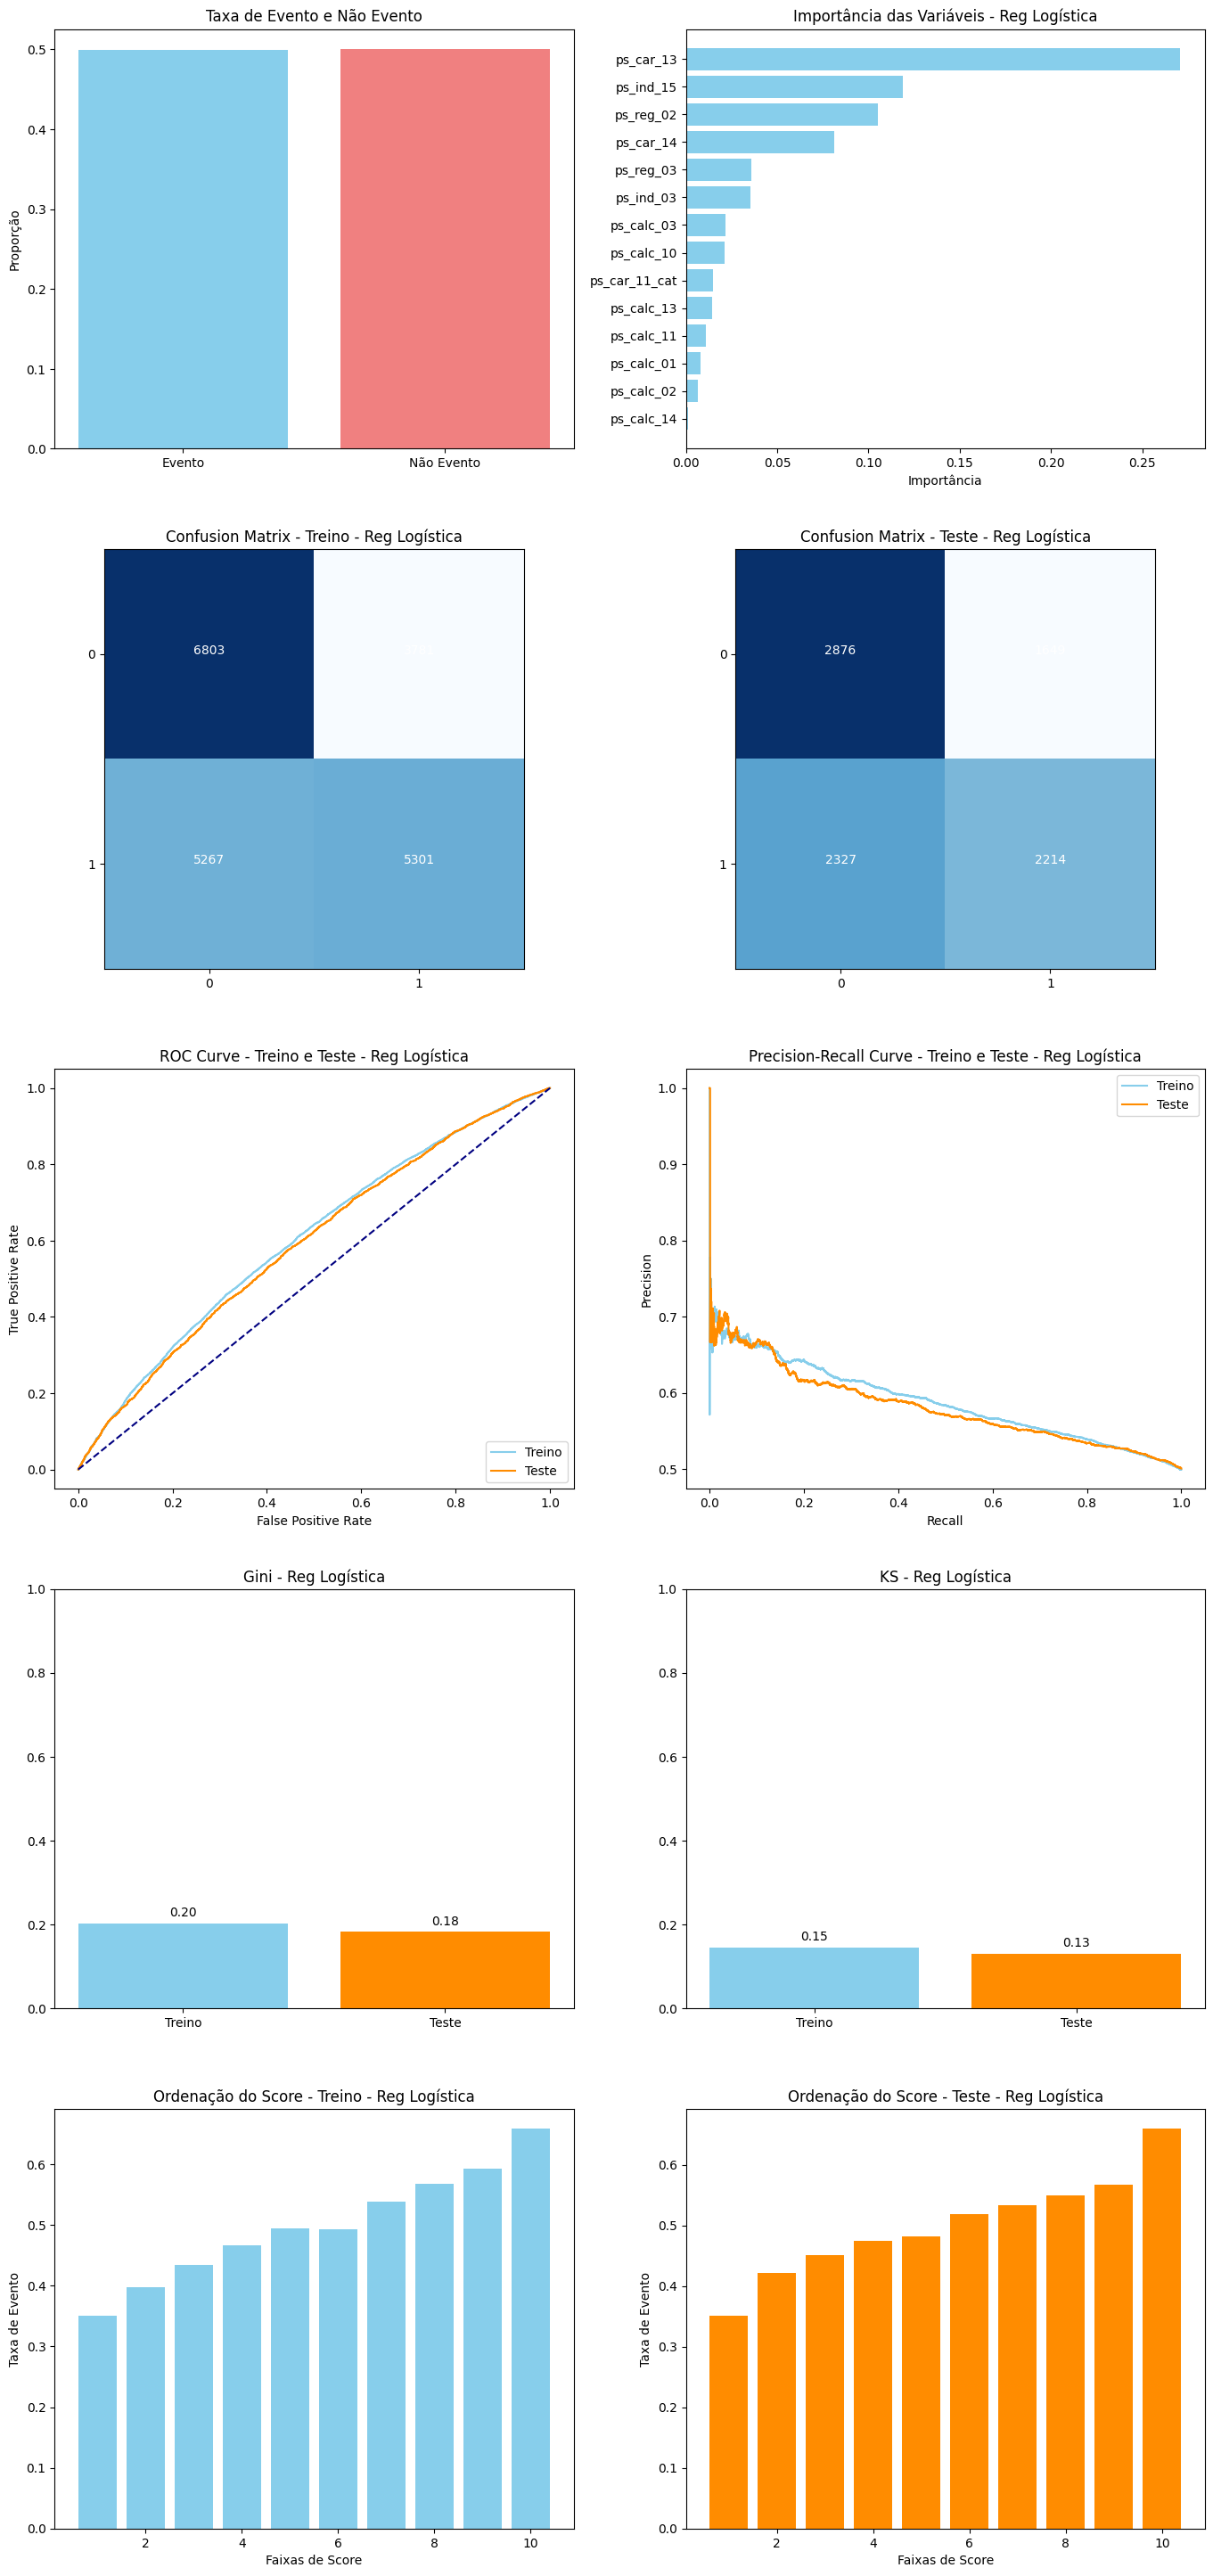

In [0]:

fun.avaliar_modelo(X_train, y_train, X_test, y_test, model_sgs,nm_modelo='Reg Logística')

Os gráficos deixam bem claro a dificuldade do modelo de capturar informações com os dados fornecidos, no gráfico da curva ROC mostra que o modelo está bem proximo da diagonal, isso mostra que o modelo está quase para o acaso, mostra claramente que o modelo não soube diferenciar eventos de não eventos e no gráfico de precisão vimos que o modelo tem uma boa precisão para poucos dados mas quando começamos a adicionar modelos ele tem uma queda abrupta de precisão e não consegue voltar.

Valores baixos na gini e no ks

Quanto ao gráfico de ordenação de score, mesmo tendo um crescimento gradativo, o crescimento é suave demais com sobreposição entre as faixas, indicando baixa capacidade de rankeamento.

### Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Definindo o modelo
modelo_FDC = RandomForestClassifier(random_state=42)

# Grid Search reduzido (mais rápido)
param_grid_rf = {
    "n_estimators": [100, 200],
    "max_depth": [5, 8, 12],
    "min_samples_split": [10, 20],
    "min_samples_leaf": [5, 10, 20],
    "max_features": ["sqrt", 0.5],
    "class_weight": ["balanced_subsample"],
    "bootstrap": [True]
}

# Grid Search
grid_FDC = GridSearchCV(
    estimator=modelo_FDC,
    param_grid=param_grid_rf,
    cv=3,                    
    scoring='roc_auc',
    n_jobs=-1,                
    verbose=2
)

# Treinando o modelo
grid_FDC.fit(X_train, y_train)

# Resultados
print("Melhores Parâmetros: ", grid_FDC.best_params_)
print("Melhor AUC: ", grid_FDC.best_score_)

# Previsões
predictions_RF = grid_FDC.best_estimator_.predict(X_test)
predprob_RF = grid_FDC.best_estimator_.predict_proba(X_test)

# Gini normalizado
gini_RF = round(fun.gini_normalizado(y_test, predprob_RF[:, 1]), 2)
print('Gini normalizado --> ', gini_RF)

# Guardando o melhor modelo
best_model_rf = grid_FDC.best_estimator_

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] END bootstrap=True, class_weight=balanced_subsample, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced_subsample, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, class_weight=balanced_subsample, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   2.1s
[CV] END bootstrap=True, class_weight=balanced_subsample, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=20, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced_subsample, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=20, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, class_weight=balanced_subsample, max_depth=5, max_features=sqrt, min

In [0]:
# Resultados Random Forest
print("\n🔹 Melhores Parâmetros: ", grid_FDC.best_params_)
print("🔹 Melhor AUC (Cross-Validation): ", round(grid_FDC.best_score_, 4))


# --- Métricas de avaliação ---
accuracy_RF = accuracy_score(y_test, predictions_RF)
precision_RF = precision_score(y_test, predictions_RF)
recall_RF = recall_score(y_test, predictions_RF)
f1_RF = f1_score(y_test, predictions_RF)
roc_auc_RF = grid_FDC.best_score_

# --- Exibição dos resultados ---
print("\n📊 Resultados do Modelo Random Forest:")
print(f"Accuracy:  {accuracy_RF:.4f}")
print(f"Precision: {precision_RF:.4f}")
print(f"Recall:    {recall_RF:.4f}")
print(f"F1-Score:  {f1_RF:.4f}")
print(f"ROC AUC:   {roc_auc_RF:.4f}")
print(f"Gini:      {gini_RF:.4f}")



🔹 Melhores Parâmetros:  {'bootstrap': True, 'class_weight': 'balanced_subsample', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 200}
🔹 Melhor AUC (Cross-Validation):  0.6062

📊 Resultados do Modelo Random Forest:
Accuracy:  0.5718
Precision: 0.5736
Recall:    0.5657
F1-Score:  0.5696
ROC AUC:   0.6062
Gini:      0.2000


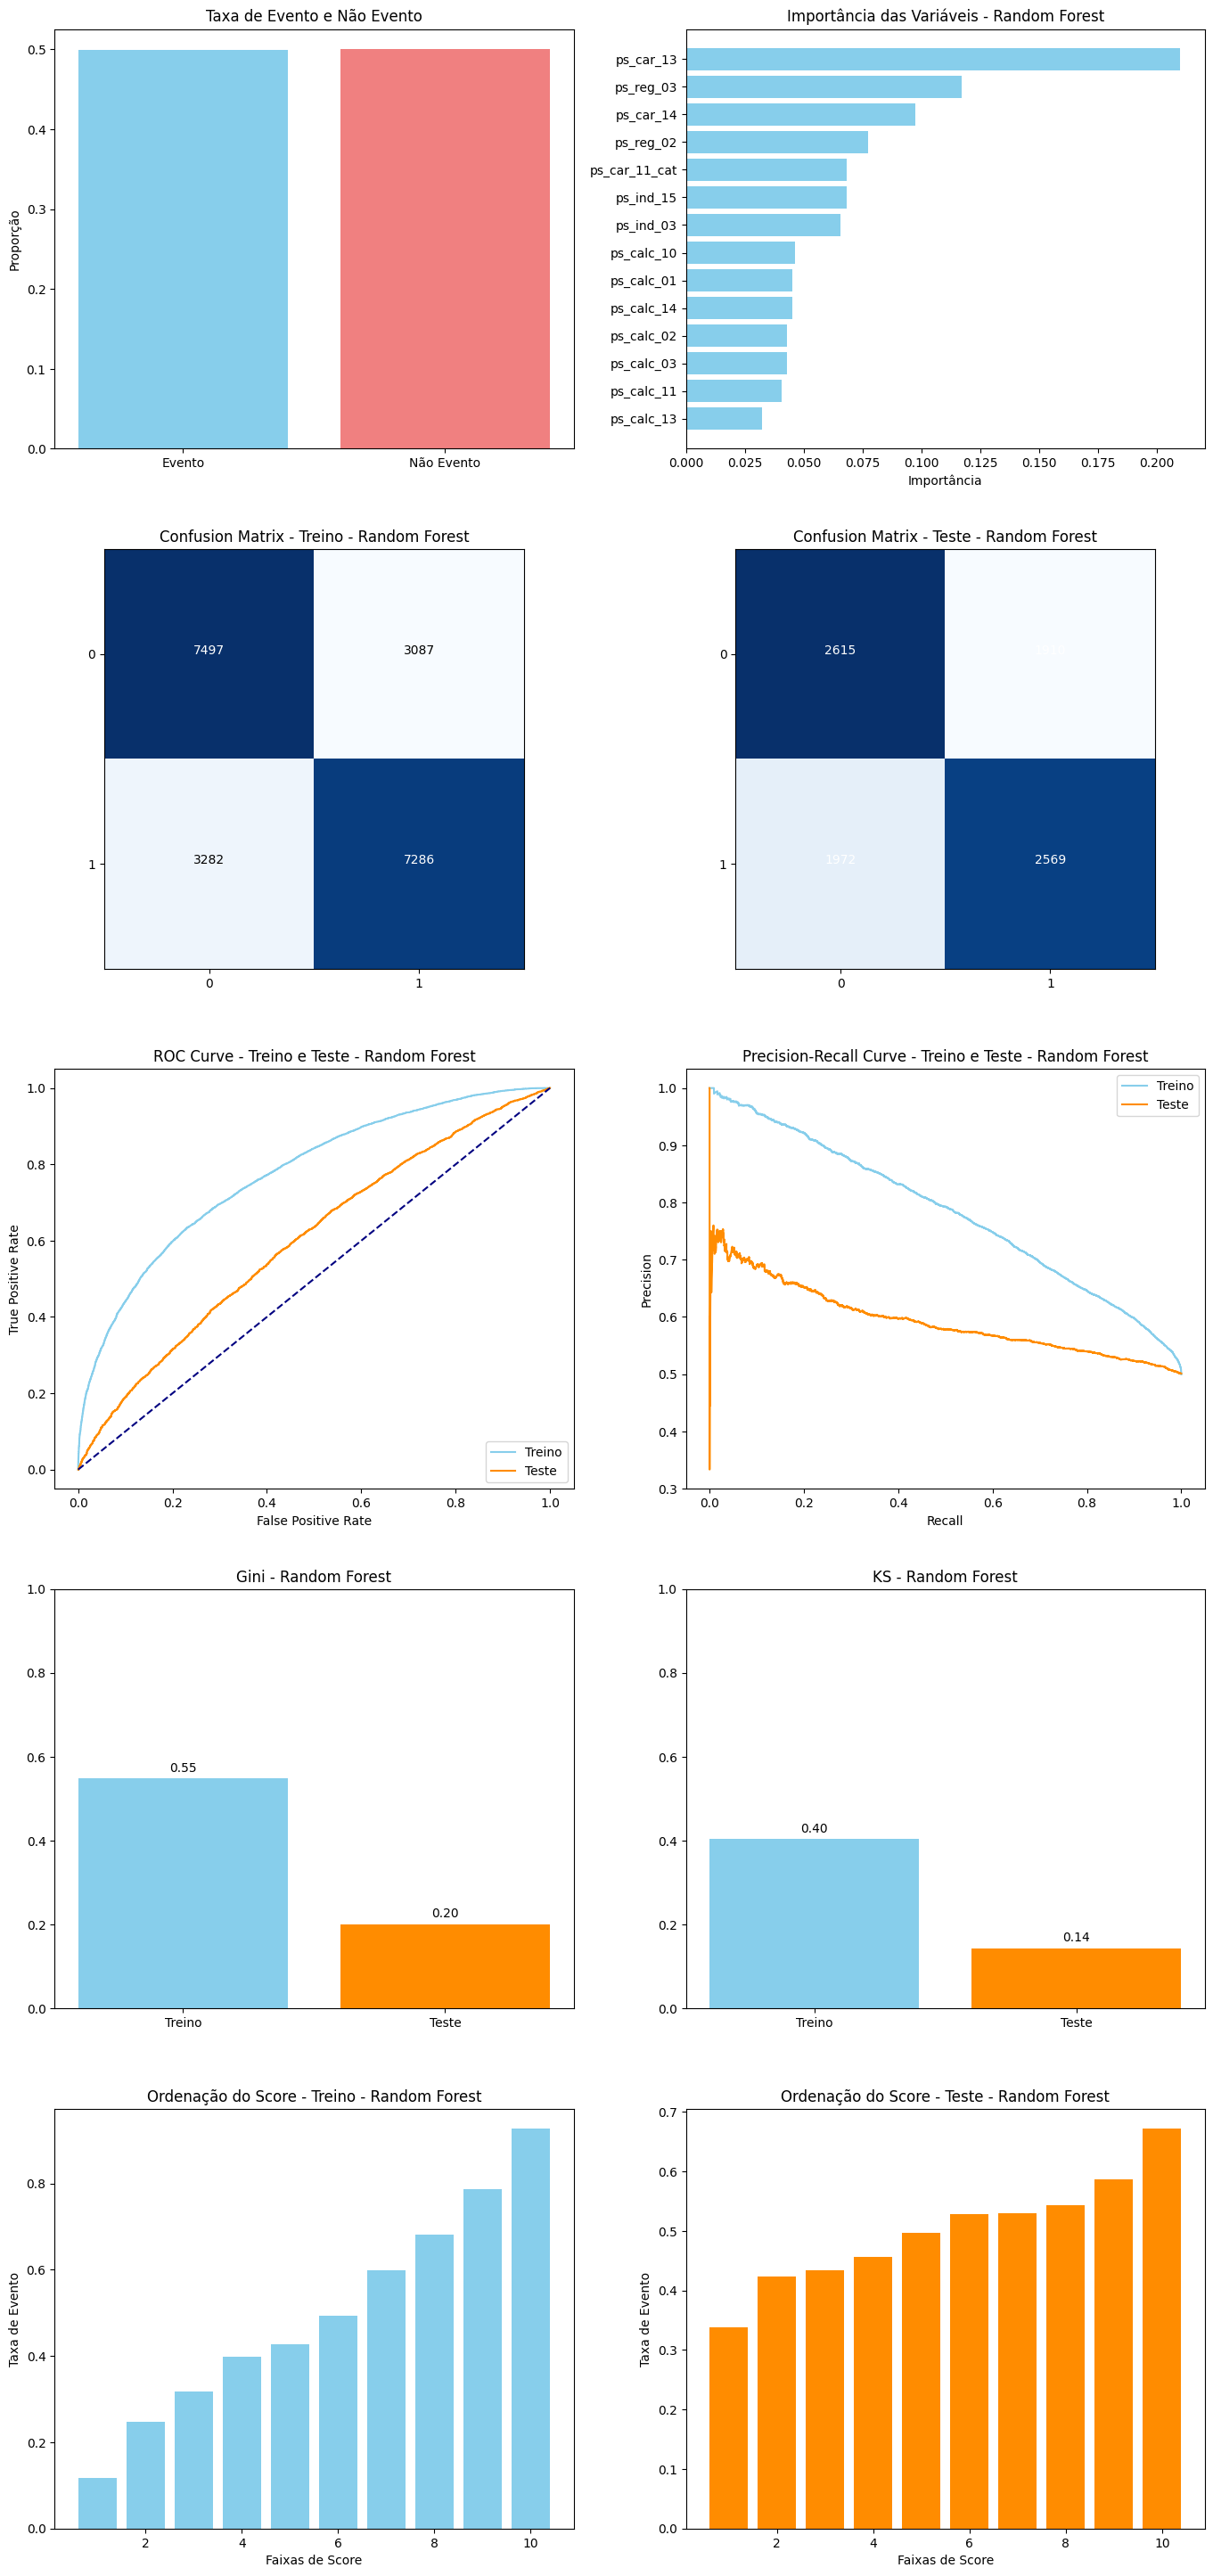

In [0]:
fun.avaliar_modelo(X_train, y_train,X_test, y_test,best_model_rf, nm_modelo='Random Forest')

Os resultados e gráficos indicam overfitting acentuado no modelo Random Forest. No conjunto de treino, o modelo apresenta boa capacidade discriminativa (Gini ≈ 0,58; KS ≈ 0,42), com curvas ROC bem acima da linha aleatória e uma ordenação de score eficiente. No entanto, esse desempenho não se sustenta fora da amostra, sugerindo que o modelo aprendeu padrões específicos do treino, e não relações generalizáveis.

No conjunto de teste, observa-se uma queda expressiva de performance (Gini ≈ 0,20; KS ≈ 0,15; AUC ≈ 0,60), com curvas ROC e Precision-Recall próximas ao comportamento aleatório. Apesar de métricas como Accuracy, Precision e Recall apresentarem valores medianos, a perda de poder discriminativo invalida o modelo para uso prático, evidenciando sua baixa capacidade de generalização.

### XGBoost

In [0]:
!pip install xgboost

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Definindo o modelo
modelo_XGB = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Calculate pos and neg for scale_pos_weight
pos = y_train.sum()
neg = len(y_train) - pos

# Grid Search
param_grid = {
    "n_estimators": [300, 600],
    "learning_rate": [0.03, 0.05],
    "max_depth": [2, 3, 4],
    "subsample": [0.7, 0.85],
    "colsample_bytree": [0.6, 0.85],
    "gamma": [0, 0.5, 1],
    "min_child_weight": [1, 5]
}

# Definindo o Grid Search
grid_XGB = GridSearchCV(
    estimator=modelo_XGB,
    param_grid=param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,               
    verbose=2
)

# Treinando o modelo
grid_XGB.fit(X_train, y_train)

# Resultados
print("Melhores Parâmetros: ", grid_XGB.best_params_)
print("Melhor AUC: ", grid_XGB.best_score_)

# Previsões
predictions_XGB = grid_XGB.best_estimator_.predict(X_test)
predprob_XGB = grid_XGB.best_estimator_.predict_proba(X_test)

# Gini normalizado
gini_XGB = round(fun.gini_normalizado(y_test, predprob_XGB[:, 1]), 2)
print('Gini normalizado --> ', gini_XGB)

# Guardando o melhor modelo
best_model_xgb = grid_XGB.best_estimator_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:53:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:53:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:53:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/t


[CV] END bootstrap=True, class_weight=balanced_subsample, max_depth=12, max_features=0.5, min_samples_leaf=10, min_samples_split=10, n_estimators=200; total time=   6.6s
[CV] END bootstrap=True, class_weight=balanced_subsample, max_depth=12, max_features=0.5, min_samples_leaf=10, min_samples_split=20, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, class_weight=balanced_subsample, max_depth=12, max_features=0.5, min_samples_leaf=10, min_samples_split=20, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, class_weight=balanced_subsample, max_depth=12, max_features=0.5, min_samples_leaf=10, min_samples_split=20, n_estimators=200; total time=   6.7s
[CV] END bootstrap=True, class_weight=balanced_subsample, max_depth=12, max_features=0.5, min_samples_leaf=10, min_samples_split=20, n_estimators=200; total time=   6.6s
[CV] END bootstrap=True, class_weight=balanced_subsample, max_depth=12, max_features=0.5, min_samples_leaf=20, min_samples_split=10, n_estimators=100

/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:53:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:53:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:53:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/t


[CV] END bootstrap=True, class_weight=balanced_subsample, max_depth=12, max_features=0.5, min_samples_leaf=10, min_samples_split=10, n_estimators=200; total time=   6.8s
[CV] END bootstrap=True, class_weight=balanced_subsample, max_depth=12, max_features=0.5, min_samples_leaf=10, min_samples_split=20, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, class_weight=balanced_subsample, max_depth=12, max_features=0.5, min_samples_leaf=10, min_samples_split=20, n_estimators=200; total time=   6.8s
[CV] END bootstrap=True, class_weight=balanced_subsample, max_depth=12, max_features=0.5, min_samples_leaf=20, min_samples_split=10, n_estimators=100; total time=   3.1s
[CV] END bootstrap=True, class_weight=balanced_subsample, max_depth=12, max_features=0.5, min_samples_leaf=20, min_samples_split=10, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, class_weight=balanced_subsample, max_depth=12, max_features=0.5, min_samples_leaf=20, min_samples_split=10, n_estimators=200

/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:53:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:53:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:53:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/t


[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=2, min_child_weight=5, n_estimators=300, subsample=0.85; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=2, min_child_weight=5, n_estimators=600, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=2, min_child_weight=5, n_estimators=600, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=2, min_child_weight=5, n_estimators=600, subsample=0.85; total time=   0.5s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.85; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.85;

/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:54:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:54:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=2, min_child_weight=5, n_estimators=600, subsample=0.85; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=2, min_child_weight=5, n_estimators=600, subsample=0.85; total time=   0.5s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.85; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=600, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=600, subsample=0.7; 

/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:54:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:54:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:54:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/t


[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.03, max_depth=4, min_child_weight=1, n_estimators=600, subsample=0.85; total time=   0.6s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.03, max_depth=4, min_child_weight=1, n_estimators=600, subsample=0.85; total time=   0.6s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.03, max_depth=4, min_child_weight=5, n_estimators=300, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.03, max_depth=4, min_child_weight=5, n_estimators=300, subsample=0.85; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.03, max_depth=4, min_child_weight=5, n_estimators=300, subsample=0.85; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.03, max_depth=4, min_child_weight=5, n_estimators=600, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.03, max_depth=4, min_child_weight=5, n_estimators=600, 

/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:54:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:54:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.03, max_depth=4, min_child_weight=5, n_estimators=300, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.03, max_depth=4, min_child_weight=5, n_estimators=300, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.03, max_depth=4, min_child_weight=5, n_estimators=300, subsample=0.85; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.03, max_depth=4, min_child_weight=5, n_estimators=600, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.03, max_depth=4, min_child_weight=5, n_estimators=600, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.03, max_depth=4, min_child_weight=5, n_estimators=600, subsample=0.85; total time=   0.6s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.05, max_depth=2, min_child_weight=1, n_estimators=300, su

/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:54:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:54:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:54:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/t


[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.03, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.03, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.85; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.03, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.85; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.03, max_depth=3, min_child_weight=1, n_estimators=600, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.03, max_depth=3, min_child_weight=1, n_estimators=600, subsample=0.85; total time=   0.5s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.03, max_depth=3, min_child_weight=1, n_estimators=600, subsample=0.85; total time=   0.5s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.03, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.7;

/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:54:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:54:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:54:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/t


[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.03, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.85; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.03, max_depth=3, min_child_weight=1, n_estimators=600, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.03, max_depth=3, min_child_weight=1, n_estimators=600, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.03, max_depth=3, min_child_weight=1, n_estimators=600, subsample=0.85; total time=   0.5s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.03, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.03, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.03, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.85; 

/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:54:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:54:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:54:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/t


[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=600, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=600, subsample=0.85; total time=   0.7s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=600, subsample=0.85; total time=   0.6s
[CV] END colsample_bytree=0.85, gamma=0, learning_rate=0.03, max_depth=2, min_child_weight=1, n_estimators=300, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.85, gamma=0, learning_rate=0.03, max_depth=2, min_child_weight=1, n_estimators=300, subsample=0.85; total time=   0.2s
[CV] END colsample_bytree=0.85, gamma=0, learning_rate=0.03, max_depth=2, min_child_weight=1, n_estimators=300, subsample=0.85; total time=   0.2s
[CV] END colsample_bytree=0.85, gamma=0, learning_rate=0.03, max_depth=2, min_child_weight=1, n_estimators=600, subsample=

/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:55:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:55:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:55:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/t


[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=600, subsample=0.85; total time=   0.5s
[CV] END colsample_bytree=0.85, gamma=0, learning_rate=0.03, max_depth=2, min_child_weight=1, n_estimators=300, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.85, gamma=0, learning_rate=0.03, max_depth=2, min_child_weight=1, n_estimators=300, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.85, gamma=0, learning_rate=0.03, max_depth=2, min_child_weight=1, n_estimators=300, subsample=0.85; total time=   0.2s
[CV] END colsample_bytree=0.85, gamma=0, learning_rate=0.03, max_depth=2, min_child_weight=1, n_estimators=600, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.85, gamma=0, learning_rate=0.03, max_depth=2, min_child_weight=1, n_estimators=600, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.85, gamma=0, learning_rate=0.03, max_depth=2, min_child_weight=1, n_estimators=600, subsample=

/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:55:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:55:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:55:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/t


[CV] END colsample_bytree=0.85, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=600, subsample=0.85; total time=   0.5s
[CV] END colsample_bytree=0.85, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.85, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.85, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.85; total time=   0.3s
[CV] END colsample_bytree=0.85, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=600, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.85, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=600, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.85, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=600, subsample

/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:55:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:55:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[CV] END colsample_bytree=0.85, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.85; total time=   0.3s
[CV] END colsample_bytree=0.85, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.85; total time=   0.3s
[CV] END colsample_bytree=0.85, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=600, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.85, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=600, subsample=0.85; total time=   0.5s
[CV] END colsample_bytree=0.85, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=600, subsample=0.85; total time=   0.5s
[CV] END colsample_bytree=0.85, gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=300, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.85, gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=300, subsamp

/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:55:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:55:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:55:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/t


[CV] END colsample_bytree=0.85, gamma=0.5, learning_rate=0.05, max_depth=2, min_child_weight=1, n_estimators=300, subsample=0.85; total time=   0.2s
[CV] END colsample_bytree=0.85, gamma=0.5, learning_rate=0.05, max_depth=2, min_child_weight=1, n_estimators=300, subsample=0.85; total time=   0.2s
[CV] END colsample_bytree=0.85, gamma=0.5, learning_rate=0.05, max_depth=2, min_child_weight=1, n_estimators=600, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.85, gamma=0.5, learning_rate=0.05, max_depth=2, min_child_weight=1, n_estimators=600, subsample=0.85; total time=   0.4s
[CV] END colsample_bytree=0.85, gamma=0.5, learning_rate=0.05, max_depth=2, min_child_weight=1, n_estimators=600, subsample=0.85; total time=   0.4s
[CV] END colsample_bytree=0.85, gamma=0.5, learning_rate=0.05, max_depth=2, min_child_weight=5, n_estimators=300, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.85, gamma=0.5, learning_rate=0.05, max_depth=2, min_child_weight=5, n_estimator

/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:56:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:56:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:56:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/t


[CV] END colsample_bytree=0.85, gamma=0.5, learning_rate=0.05, max_depth=2, min_child_weight=1, n_estimators=600, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.85, gamma=0.5, learning_rate=0.05, max_depth=2, min_child_weight=1, n_estimators=600, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.85, gamma=0.5, learning_rate=0.05, max_depth=2, min_child_weight=1, n_estimators=600, subsample=0.85; total time=   0.4s
[CV] END colsample_bytree=0.85, gamma=0.5, learning_rate=0.05, max_depth=2, min_child_weight=5, n_estimators=300, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.85, gamma=0.5, learning_rate=0.05, max_depth=2, min_child_weight=5, n_estimators=300, subsample=0.85; total time=   0.2s
[CV] END colsample_bytree=0.85, gamma=0.5, learning_rate=0.05, max_depth=2, min_child_weight=5, n_estimators=300, subsample=0.85; total time=   0.2s
[CV] END colsample_bytree=0.85, gamma=0.5, learning_rate=0.05, max_depth=2, min_child_weight=5, n_estimators

/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:56:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:56:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:56:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-0db45594-659c-48ba-af8e-f2b7c5ae60b3/lib/python3.11/site-packages/xgboost/t

Melhores Parâmetros:  {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.03, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 600, 'subsample': 0.7}
Melhor AUC:  0.6099390479608734
Gini normalizado -->  0.22


In [0]:
# Resultados XGBoost
print("\n🔹 Melhores Parâmetros: ", grid_XGB.best_params_)
print("🔹 Melhor AUC (Cross-Validation): ", round(grid_XGB.best_score_, 4))


# --- Métricas de avaliação ---
accuracy_XGB = accuracy_score(y_test, predictions_XGB)
precision_XGB = precision_score(y_test, predictions_XGB)
recall_XGB = recall_score(y_test, predictions_XGB)
f1_XGB = f1_score(y_test, predictions_XGB)
roc_auc_XGB = grid_XGB.best_score_

# --- Exibição dos resultados ---
print("\n📊 Resultados do Modelo XGBoost:")
print(f"Accuracy:  {accuracy_XGB:.4f}")
print(f"Precision: {precision_XGB:.4f}")
print(f"Recall:    {recall_XGB:.4f}")
print(f"F1-Score:  {f1_XGB:.4f}")
print(f"ROC AUC:   {roc_auc_XGB:.4f}")
print(f"Gini:      {gini_XGB:.4f}")

# Guardando o melhor modelo
best_model_xgb = grid_XGB.best_estimator_



🔹 Melhores Parâmetros:  {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.03, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 600, 'subsample': 0.7}
🔹 Melhor AUC (Cross-Validation):  0.6099

📊 Resultados do Modelo XGBoost:
Accuracy:  0.5735
Precision: 0.5768
Recall:    0.5574
F1-Score:  0.5669
ROC AUC:   0.6099
Gini:      0.2200


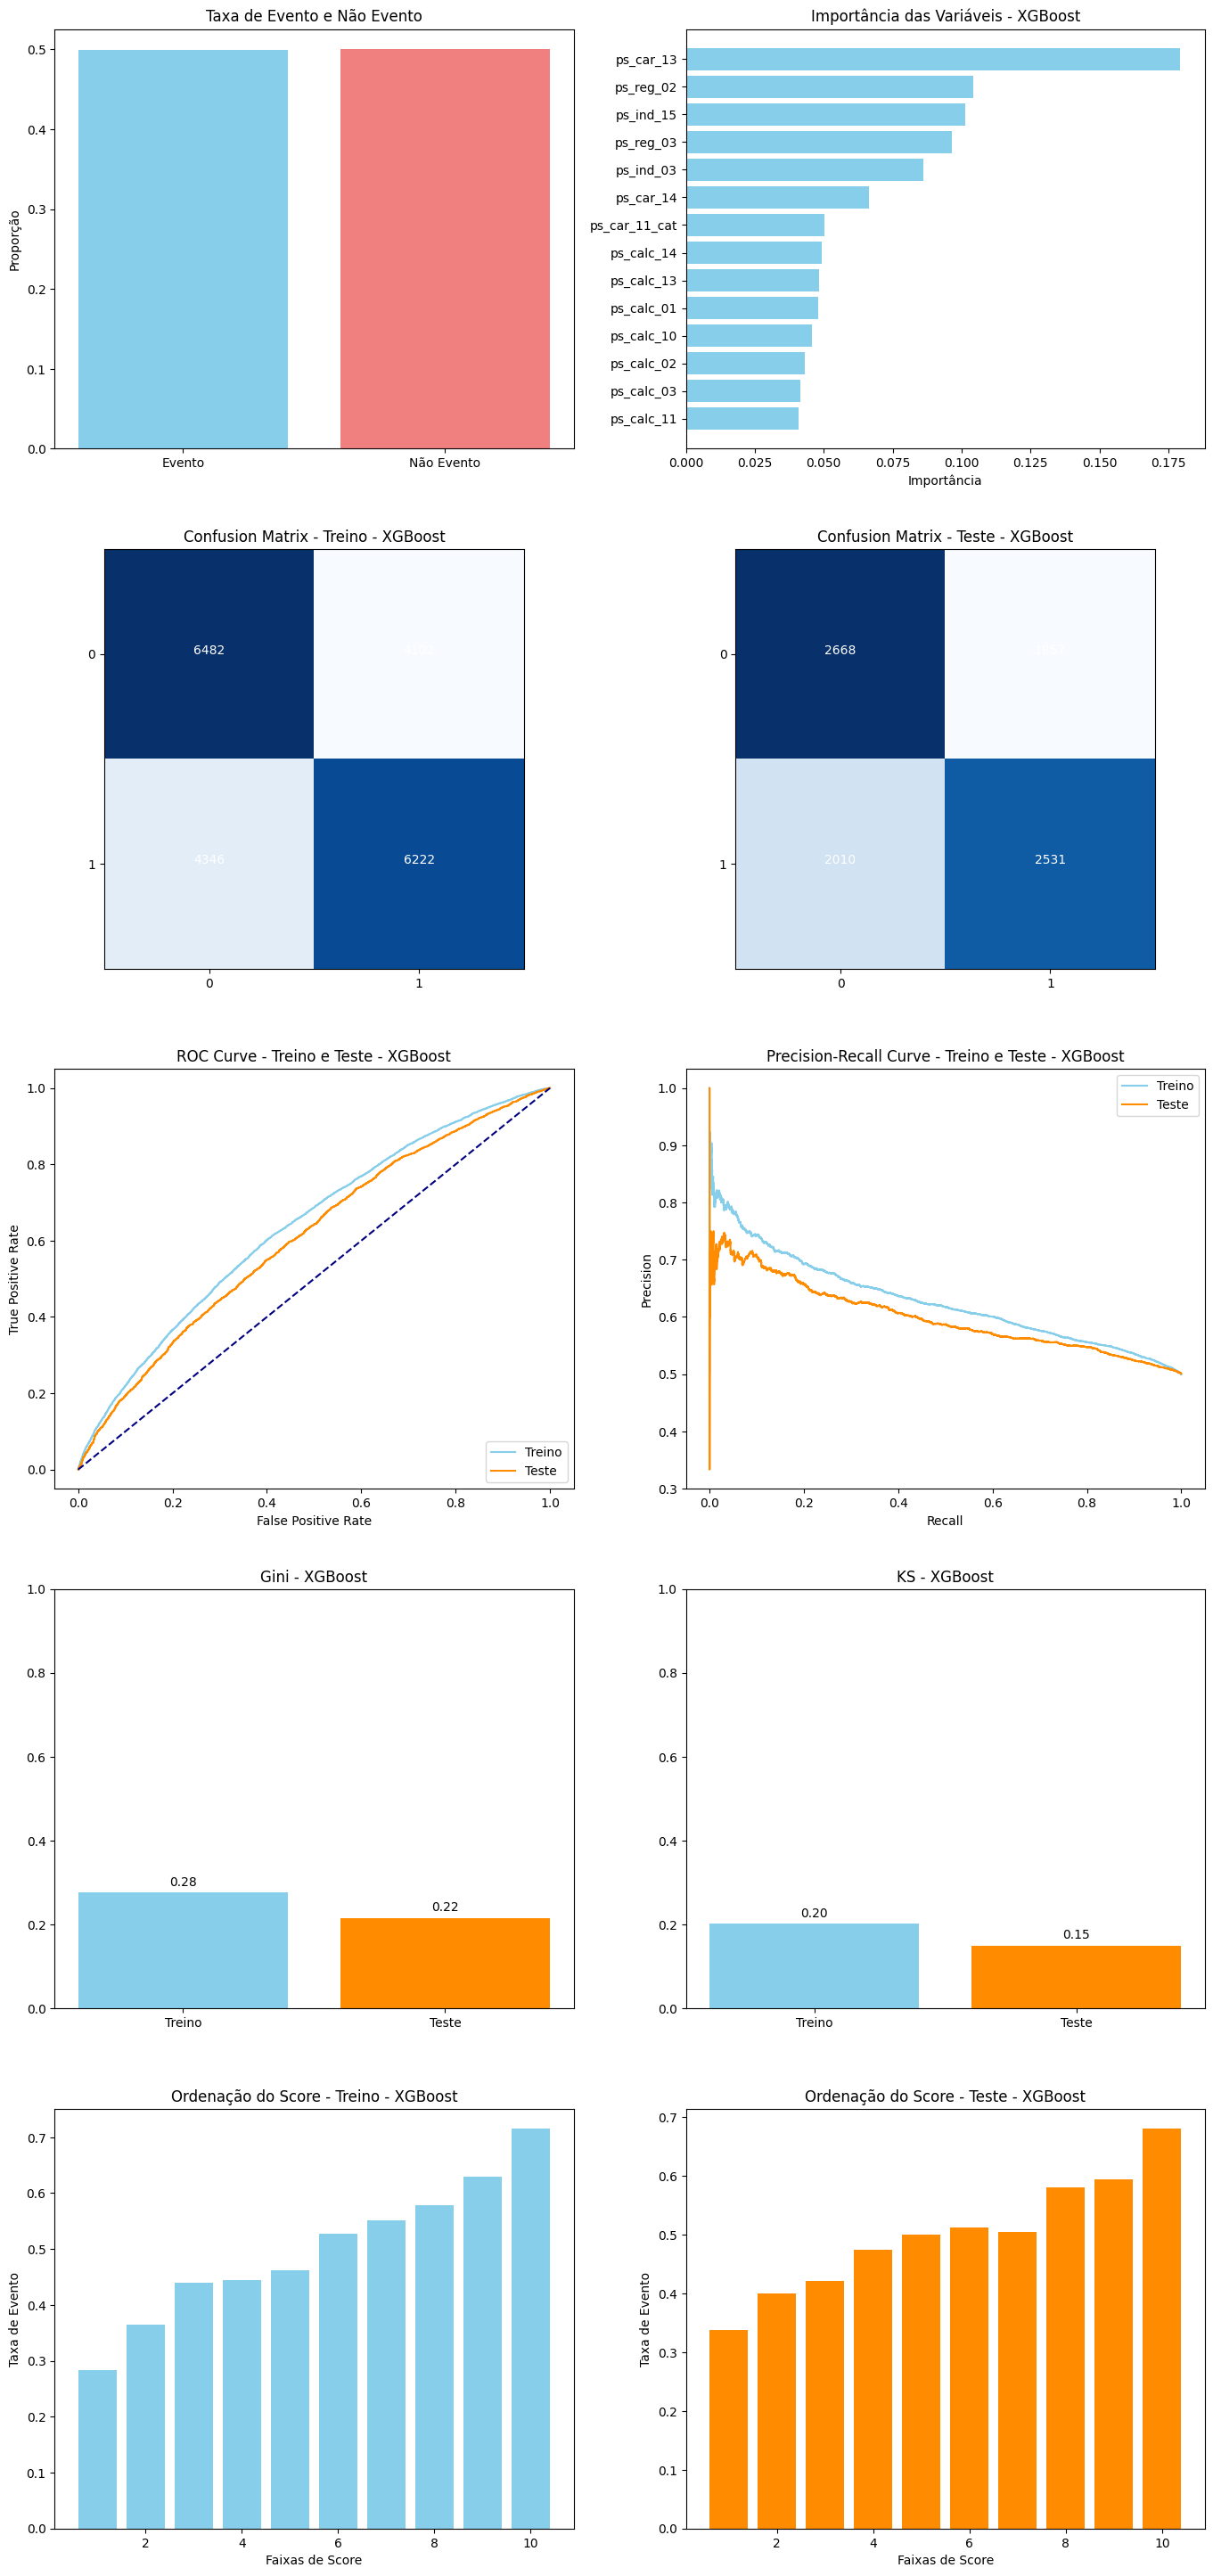

In [0]:
fun.avaliar_modelo(X_train, y_train,X_test, y_test,best_model_xgb, nm_modelo='XGBoost')

Os resultados do XGBoost indicam um modelo mais estável e com baixo overfitting quando comparado ao Random Forest. As curvas ROC de treino e teste permanecem próximas entre si, com AUC ≈ 0,61 (Gini ≈ 0,21), o que demonstra consistência entre as amostras, embora com capacidade discriminativa ainda limitada. As curvas Precision-Recall mostram precision e recall moderados (≈0,55–0,58), com queda inicial da precisão ao aumentar o recall — comportamento esperado em bases desafiadoras — seguido de estabilização, indicando aprendizado coerente, porém fraco.

Apesar da baixa diferença entre Gini e KS de treino e teste (confirmando o baixo overfitting), a ordenação de score no conjunto de teste apresenta sobreposição entre decis, reduzindo o poder de ranqueamento. Isso sugere que o modelo captura parte do sinal, mas ainda não diferencia bem eventos e não-eventos em níveis operacionais. Em síntese, o XGBoost entrega robustez e generalização, porém com performance mediana, indicando espaço para ganhos via tuning mais profundo, engenharia de atributos ou ajustes no balanceamento.

### LightGBM

In [0]:
!pip install lightgbm

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
# @title
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

# Definindo o modelo
modelo_LGB = lgb.LGBMClassifier(random_state=42)

# Grid Search 
param_grid_lgbm = {
    "max_depth": [-1, 6, 8],
    "num_leaves": [31, 63],
    "min_data_in_leaf": [30, 80],

    "learning_rate": [0.01, 0.03],
    "n_estimators": [800, 1600],

    "feature_fraction": [0.7, 0.85],
    "bagging_fraction": [0.7, 0.85],
    "bagging_freq": [1],

    "min_gain_to_split": [0.0, 0.1],
    "lambda_l1": [0.0, 0.1],
    "lambda_l2": [1, 5],
}


# Definindo o Grid Search
grid_LGB = GridSearchCV(
    estimator=modelo_LGB,
    param_grid=param_grid,
    cv=3,                    # reduzido de 5 para 3 folds
    scoring='roc_auc',
    n_jobs=-1,               # usa todos os núcleos disponíveis
    verbose=2
)

# Treinando o modelo
grid_LGB.fit(X_train, y_train)

# Resultados
print("Melhores Parâmetros: ", grid_LGB.best_params_)
print("Melhor AUC: ", grid_LGB.best_score_)

# Previsões
predictions_LGBM = grid_LGB.best_estimator_.predict(X_test)
predprob = grid_LGB.best_estimator_.predict_proba(X_test)

# Gini normalizado (mesmo método do XGBoost)
gini_LGBM = round(fun.gini_normalizado(y_test, predprob[:, 1]), 2)
print('Gini normalizado --> ', gini_LGBM)

# Guardando o melhor modelo
best_model_lgb = grid_LGB.best_estimator_

Fitting 3 folds for each of 288 candidates, totalling 864 fits

[CV] END colsample_bytree=0.85, gamma=1, learning_rate=0.03, max_depth=3, min_child_weight=5, n_estimators=600, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.85, gamma=1, learning_rate=0.03, max_depth=3, min_child_weight=5, n_estimators=600, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.85, gamma=1, learning_rate=0.03, max_depth=3, min_child_weight=5, n_estimators=600, subsample=0.85; total time=   0.5s
[CV] END colsample_bytree=0.85, gamma=1, learning_rate=0.03, max_depth=4, min_child_weight=1, n_estimators=300, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.85, gamma=1, learning_rate=0.03, max_depth=4, min_child_weight=1, n_estimators=300, subsample=0.85; total time=   0.3s
[CV] END colsample_bytree=0.85, gamma=1, learning_rate=0.03, max_depth=4, min_child_weight=1, n_estimators=300, subsample=0.85; total time=   0.3s
[CV] END colsample_bytree=0.85, gamma=1, learning_rate=0.

In [0]:

# Resultados LightGBM
print("\n🔹 Melhores Parâmetros: ", grid_LGB.best_params_)
print("🔹 Melhor AUC (Cross-Validation): ", round(grid_LGB.best_score_, 4))


# --- Métricas de avaliação ---
accuracy_LGB = accuracy_score(y_test, predictions_LGBM)
precision_LGB = precision_score(y_test, predictions_LGBM)
recall_LGB = recall_score(y_test, predictions_LGBM)
f1_LGB = f1_score(y_test, predictions_LGBM)
roc_auc_LGB = grid_LGB.best_score_

# --- Exibição dos resultados ---
print("\n📊 Resultados do Modelo XGBoost:")
print(f"Accuracy:  {accuracy_LGB:.4f}")
print(f"Precision: {precision_LGB:.4f}")
print(f"Recall:    {recall_LGB:.4f}")
print(f"F1-Score:  {f1_LGB:.4f}")
print(f"ROC AUC:   {roc_auc_LGB:.4f}")
print(f"Gini:      {gini_LGBM:.4f}")

# Guardando o melhor modelo
best_model_lgb = grid_LGB.best_estimator_



🔹 Melhores Parâmetros:  {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.7}
🔹 Melhor AUC (Cross-Validation):  0.6088

📊 Resultados do Modelo XGBoost:
Accuracy:  0.5743
Precision: 0.5782
Recall:    0.5554
F1-Score:  0.5666
ROC AUC:   0.6088
Gini:      0.2100


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma


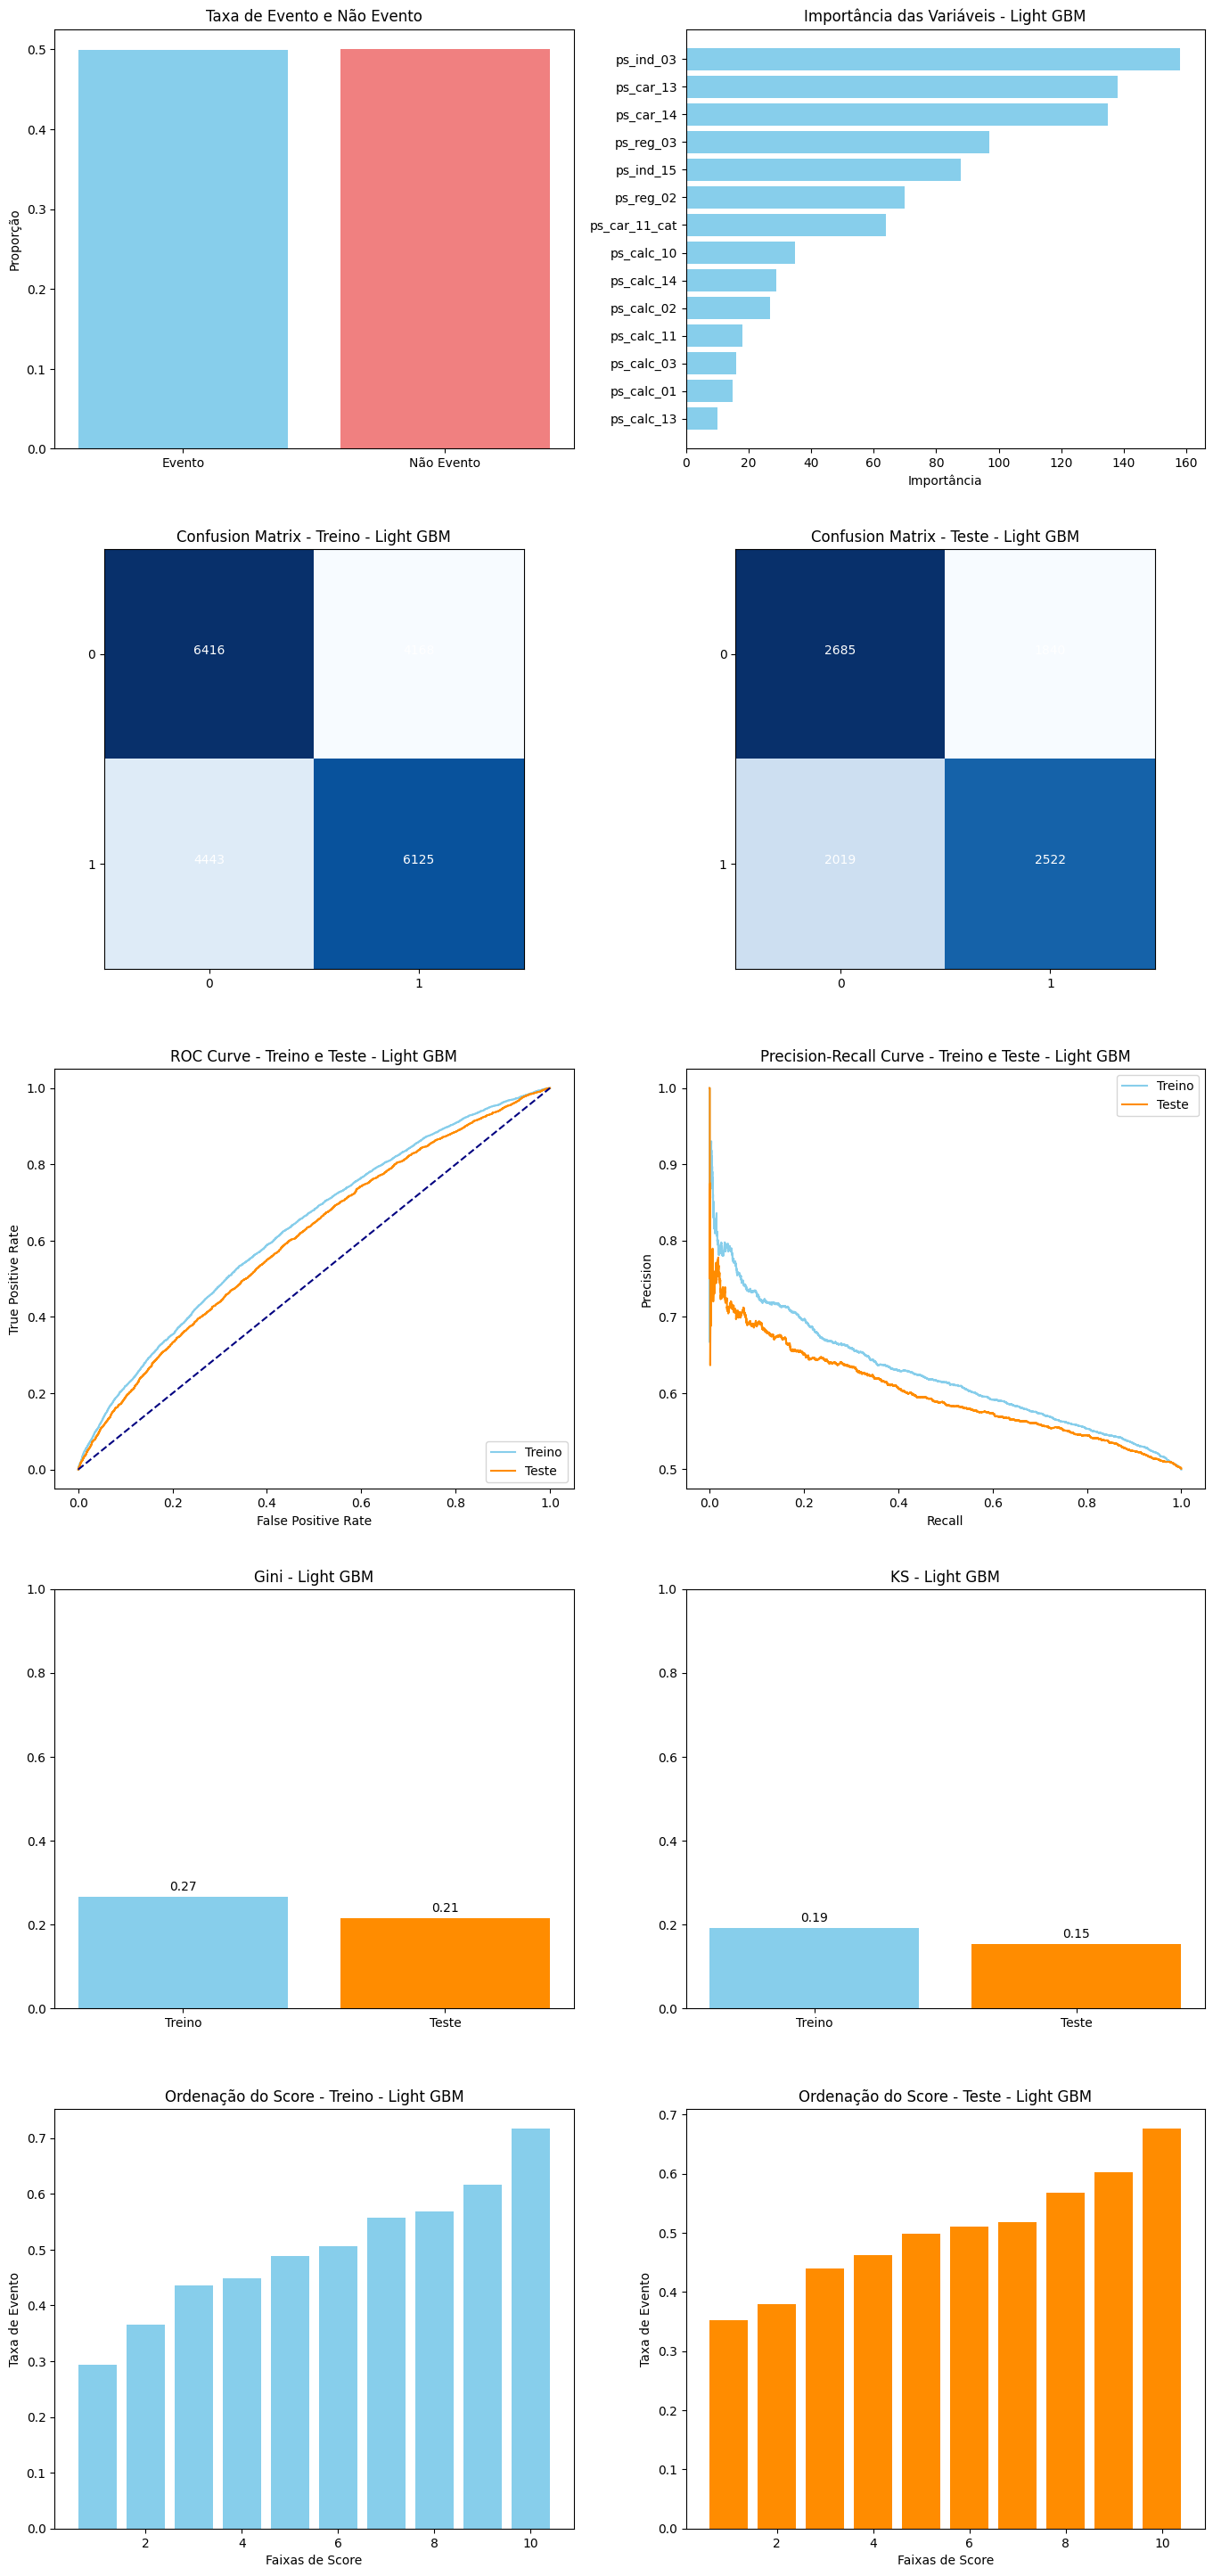

In [0]:
fun.avaliar_modelo(X_train, y_train,X_test, y_test,best_model_lgb, nm_modelo='Light GBM')

O LightGBM apresenta comportamento muito semelhante ao XGBoost, com boa estabilidade entre treino e teste e baixo overfitting, evidenciado pela pequena diferença entre Gini (≈0,29 treino vs. ≈0,21 teste) e KS (≈0,21 vs. ≈0,15). As curvas ROC permanecem próximas entre si e acima da aleatoriedade, indicando consistência, porém com capacidade discriminativa ainda moderada (AUC ≈ 0,60).

Apesar de uma leve melhora em Accuracy e F1-score, observa-se queda marginal na Precision e ROC AUC em relação ao XGBoost, mantendo métricas em patamar mediano. A ordenação de score no teste mostra crescimento progressivo da taxa de evento, mas ainda com sobreposição entre decis, o que limita o poder de ranqueamento.

### CatBoost

In [0]:
!pip install catboost

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np

# --- identificar categóricas
cat_cols = [c for c in X_train.columns if c.endswith("_cat")]
cat_idx  = [X_train.columns.get_loc(c) for c in cat_cols]

# --- converter cat cols para string (treino e teste)
X_train_cb = X_train.copy()
X_test_cb  = X_test.copy()

X_train_cb[cat_cols] = X_train_cb[cat_cols].astype("string").fillna("NA")
X_test_cb[cat_cols]  = X_test_cb[cat_cols].astype("string").fillna("NA")

# --- modelo
model = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    verbose=0,
    auto_class_weights="Balanced",
    allow_writing_files=False
)

param_grid = {
    "learning_rate": [0.01, 0.03, 0.05],
    "depth": [4, 6, 8],
    "l2_leaf_reg": [3, 5, 10],
    "iterations": [800, 1600]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_cat = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=cv,
    verbose=2,
    scoring="roc_auc",
    n_jobs=-1
)

# --- fit (mantido)
grid_cat.fit(X_train_cb, y_train, cat_features=cat_idx)

print("Melhores Parâmetros:", grid_cat.best_params_)
print("Melhor AUC (CV):", grid_cat.best_score_)

best_model_cat = grid_cat.best_estimator_

predprob = best_model_cat.predict_proba(X_test_cb)[:, 1]

auc_test = roc_auc_score(y_test, predprob)
gini_test = 2 * auc_test - 1

print("AUC Teste:", round(auc_test, 6))
print("Gini Teste:", round(gini_test, 6))

Fitting 5 folds for each of 54 candidates, totalling 270 fits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

In [0]:
predictions_cat = grid_cat.best_estimator_.predict(X_test_cb)

In [0]:
# Resultados CatBoost
print("\n🔹 Melhores Parâmetros: ", grid_cat.best_params_)
print("🔹 Melhor AUC (Cross-Validation): ", round(grid_cat.best_score_, 4))


# --- Métricas de avaliação ---
accuracy_Cat = accuracy_score(y_test, predictions_cat)
precision_Cat = precision_score(y_test, predictions_cat)
recall_Cat = recall_score(y_test, predictions_cat)
f1_Cat = f1_score(y_test, predictions_cat)
roc_auc_Cat = grid_cat.best_score_

# --- Exibição dos resultados ---
print("\n📊 Resultados do Modelo CatBoost:")
print(f"Accuracy:  {accuracy_Cat:.4f}")
print(f"Precision: {precision_Cat:.4f}")
print(f"Recall:    {recall_Cat:.4f}")
print(f"F1-Score:  {f1_Cat:.4f}")
print(f"ROC AUC:   {roc_auc_Cat:.4f}")
print(f"Gini:      {gini_test:.4f}")

# Guardando o melhor modelo
best_model_cat = grid_cat.best_estimator_



🔹 Melhores Parâmetros:  {'depth': 4, 'iterations': 1600, 'l2_leaf_reg': 10, 'learning_rate': 0.01}
🔹 Melhor AUC (Cross-Validation):  0.6144

📊 Resultados do Modelo CatBoost:
Accuracy:  0.5793
Precision: 0.5824
Recall:    0.5660
F1-Score:  0.5740
ROC AUC:   0.6144
Gini:      0.2218


In [0]:
def avaliar_modelo(X_train, y_train, X_test, y_test, modelo, nm_modelo):
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    import itertools
    from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, roc_auc_score

    def calcular_ks_statistic(y_true, y_score):
        df = pd.DataFrame({'y_true': y_true, 'y_score': y_score})
        df = df.sort_values(by='y_score', ascending=False).reset_index(drop=True)

        total_events = df['y_true'].sum()
        total_non_events = len(df) - total_events

        cumulative_events = df['y_true'].cumsum()
        cumulative_non_events = (1 - df['y_true']).cumsum()

        tpr = cumulative_events / total_events if total_events > 0 else np.zeros(len(df))
        fpr = cumulative_non_events / total_non_events if total_non_events > 0 else np.zeros(len(df))

        ks_statistic = np.max(np.abs(tpr - fpr))
        return ks_statistic

    feature_names = list(X_train.columns)
    # Criação da figura e dos eixos
    fig, axs = plt.subplots(5, 2, figsize=(15, 30))  # Ajustado para incluir novos gráficos
    plt.tight_layout(pad=6.0)

    # Cor azul claro
    cor = 'skyblue'

    # Taxa de Evento e Não Evento
    event_rate = np.mean(y_train)
    non_event_rate = 1 - event_rate
    axs[0, 0].bar(['Evento', 'Não Evento'], [event_rate, non_event_rate], color=[cor, 'lightcoral'])
    axs[0, 0].set_title('Taxa de Evento e Não Evento')
    axs[0, 0].set_ylabel('Proporção')

    # Importância dos Atributos
 # Importância dos Atributos (suporta sklearn e CatBoost)
    importancias = None

# CatBoost: usar get_feature_importance
    if hasattr(modelo, "get_feature_importance"):
      try:
        # Melhor: baseado no impacto real na predição (mais interpretável)
        importancias = modelo.get_feature_importance(type="PredictionValuesChange")
      except:
        # fallback
        importancias = modelo.get_feature_importance()
    elif hasattr(modelo, "coef_"):
      importancias = np.abs(modelo.coef_[0])
    elif hasattr(modelo, "feature_importances_"):
      importancias = modelo.feature_importances_

    if importancias is not None:
      importancias_df = pd.DataFrame({"feature": feature_names, "importance": importancias})
      importancias_df = importancias_df.sort_values(by="importance", ascending=True)

      axs[0, 1].barh(importancias_df["feature"], importancias_df["importance"], color=cor)
      axs[0, 1].set_title("Importância das Variáveis - " + nm_modelo)
      axs[0, 1].set_xlabel("Importância")
    else:
      axs[0, 1].axis("off")

    # Confusion Matrix - Treino
    y_pred_train = modelo.predict(X_train)
    cm_train = confusion_matrix(y_train, y_pred_train)
    axs[1, 0].imshow(cm_train, interpolation='nearest', cmap=plt.cm.Blues)
    axs[1, 0].set_title('Confusion Matrix - Treino - ' + nm_modelo)
    axs[1, 0].set_xticks([0, 1])
    axs[1, 0].set_yticks([0, 1])
    axs[1, 0].set_xticklabels(['0', '1'])
    axs[1, 0].set_yticklabels(['0', '1'])
    thresh = cm_train.max() / 2.
    for i, j in itertools.product(range(cm_train.shape[0]), range(cm_train.shape[1])):
        axs[1, 0].text(j, i, format(cm_train[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm_train[i, j] > thresh else "black")

    # Confusion Matrix - Teste
    y_pred_test = modelo.predict(X_test)
    cm_test = confusion_matrix(y_test, y_pred_test)
    axs[1, 1].imshow(cm_test, interpolation='nearest', cmap=plt.cm.Blues)
    axs[1, 1].set_title('Confusion Matrix - Teste - ' + nm_modelo)
    axs[1, 1].set_xticks([0, 1])
    axs[1, 1].set_yticks([0, 1])
    axs[1, 1].set_xticklabels(['0', '1'])
    axs[1, 1].set_yticklabels(['0', '1'])
    thresh = cm_test.max() / 2.
    for i, j in itertools.product(range(cm_test.shape[0]), range(cm_test.shape[1])):
        axs[1, 1].text(j, i, format(cm_test[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm_test[i, j] > thresh else "black")

    # ROC Curve - Treino e Teste
    y_score_train = modelo.predict_proba(X_train)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_score_train)
    axs[2, 0].plot(fpr_train, tpr_train, color=cor, label='Treino')

    y_score_test = modelo.predict_proba(X_test)[:, 1]
    fpr_test, tpr_test, _ = roc_curve(y_test, y_score_test)
    axs[2, 0].plot(fpr_test, tpr_test, color='darkorange', label='Teste')

    axs[2, 0].plot([0, 1], [0, 1], color='navy', linestyle='--')
    axs[2, 0].set_title('ROC Curve - Treino e Teste - ' + nm_modelo)
    axs[2, 0].set_xlabel('False Positive Rate')
    axs[2, 0].set_ylabel('True Positive Rate')
    axs[2, 0].legend(loc="lower right")

    # Precision-Recall Curve - Treino e Teste
    precision_train, recall_train, _ = precision_recall_curve(y_train, y_score_train)
    axs[2, 1].plot(recall_train, precision_train, color=cor, label='Treino')

    precision_test, recall_test, _ = precision_recall_curve(y_test, y_score_test)
    axs[2, 1].plot(recall_test, precision_test, color='darkorange', label='Teste')

    axs[2, 1].set_title('Precision-Recall Curve - Treino e Teste - ' + nm_modelo)
    axs[2, 1].set_xlabel('Recall')
    axs[2, 1].set_ylabel('Precision')
    axs[2, 1].legend(loc="upper right")

    # Gini - Treino e Teste
    auc_train = roc_auc_score(y_train, y_score_train)
    gini_train = 2 * auc_train - 1
    auc_test = roc_auc_score(y_test, y_score_test)
    gini_test = 2 * auc_test - 1
    axs[3, 0].bar(['Treino', 'Teste'], [gini_train, gini_test], color=[cor, 'darkorange'])
    axs[3, 0].set_title('Gini - ' + nm_modelo)
    axs[3, 0].set_ylim(0, 1)
    axs[3, 0].text('Treino', gini_train + 0.01, f'{gini_train:.2f}', ha='center', va='bottom')
    axs[3, 0].text('Teste', gini_test + 0.01, f'{gini_test:.2f}', ha='center', va='bottom')

    # KS - Treino e Teste
    ks_train = calcular_ks_statistic(y_train, y_score_train)
    ks_test = calcular_ks_statistic(y_test, y_score_test)
    axs[3, 1].bar(['Treino', 'Teste'], [ks_train, ks_test], color=[cor, 'darkorange'])
    axs[3, 1].set_title('KS - ' + nm_modelo)
    axs[3, 1].set_ylim(0, 1)
    axs[3, 1].text('Treino', ks_train + 0.01, f'{ks_train:.2f}', ha='center', va='bottom')
    axs[3, 1].text('Teste', ks_test + 0.01, f'{ks_test:.2f}', ha='center', va='bottom')


    # Decile Analysis - Teste
    scores = modelo.predict_proba(X_test)[:, 1]
    noise = np.random.uniform(0, 0.0001, size=scores.shape)  # Adiciona um pequeno ruído
    scores += noise
    deciles = pd.qcut(scores, q=10, duplicates='drop')
    decile_analysis = y_test.groupby(deciles).mean()
    axs[4, 1].bar(range(1, len(decile_analysis) + 1), decile_analysis, color='darkorange')
    axs[4, 1].set_title('Ordenação do Score - Teste - ' + nm_modelo)
    axs[4, 1].set_xlabel('Faixas de Score')
    axs[4, 1].set_ylabel('Taxa de Evento')

    # Decile Analysis - Treino
    scores_train = modelo.predict_proba(X_train)[:, 1]
    noise = np.random.uniform(0, 0.0001, size=scores_train.shape)  # Adiciona um pequeno ruído
    scores_train += noise
    deciles_train = pd.qcut(scores_train, q=10, duplicates='drop')
    decile_analysis_train = y_train.groupby(deciles_train).mean()
    axs[4, 0].bar(range(1, len(decile_analysis_train) + 1), decile_analysis_train, color=cor)
    axs[4, 0].set_title('Ordenação do Score - Treino - ' + nm_modelo)
    axs[4, 0].set_xlabel('Faixas de Score')
    axs[4, 0].set_ylabel('Taxa de Evento')

    # Mostrar os gráficos
    plt.show()

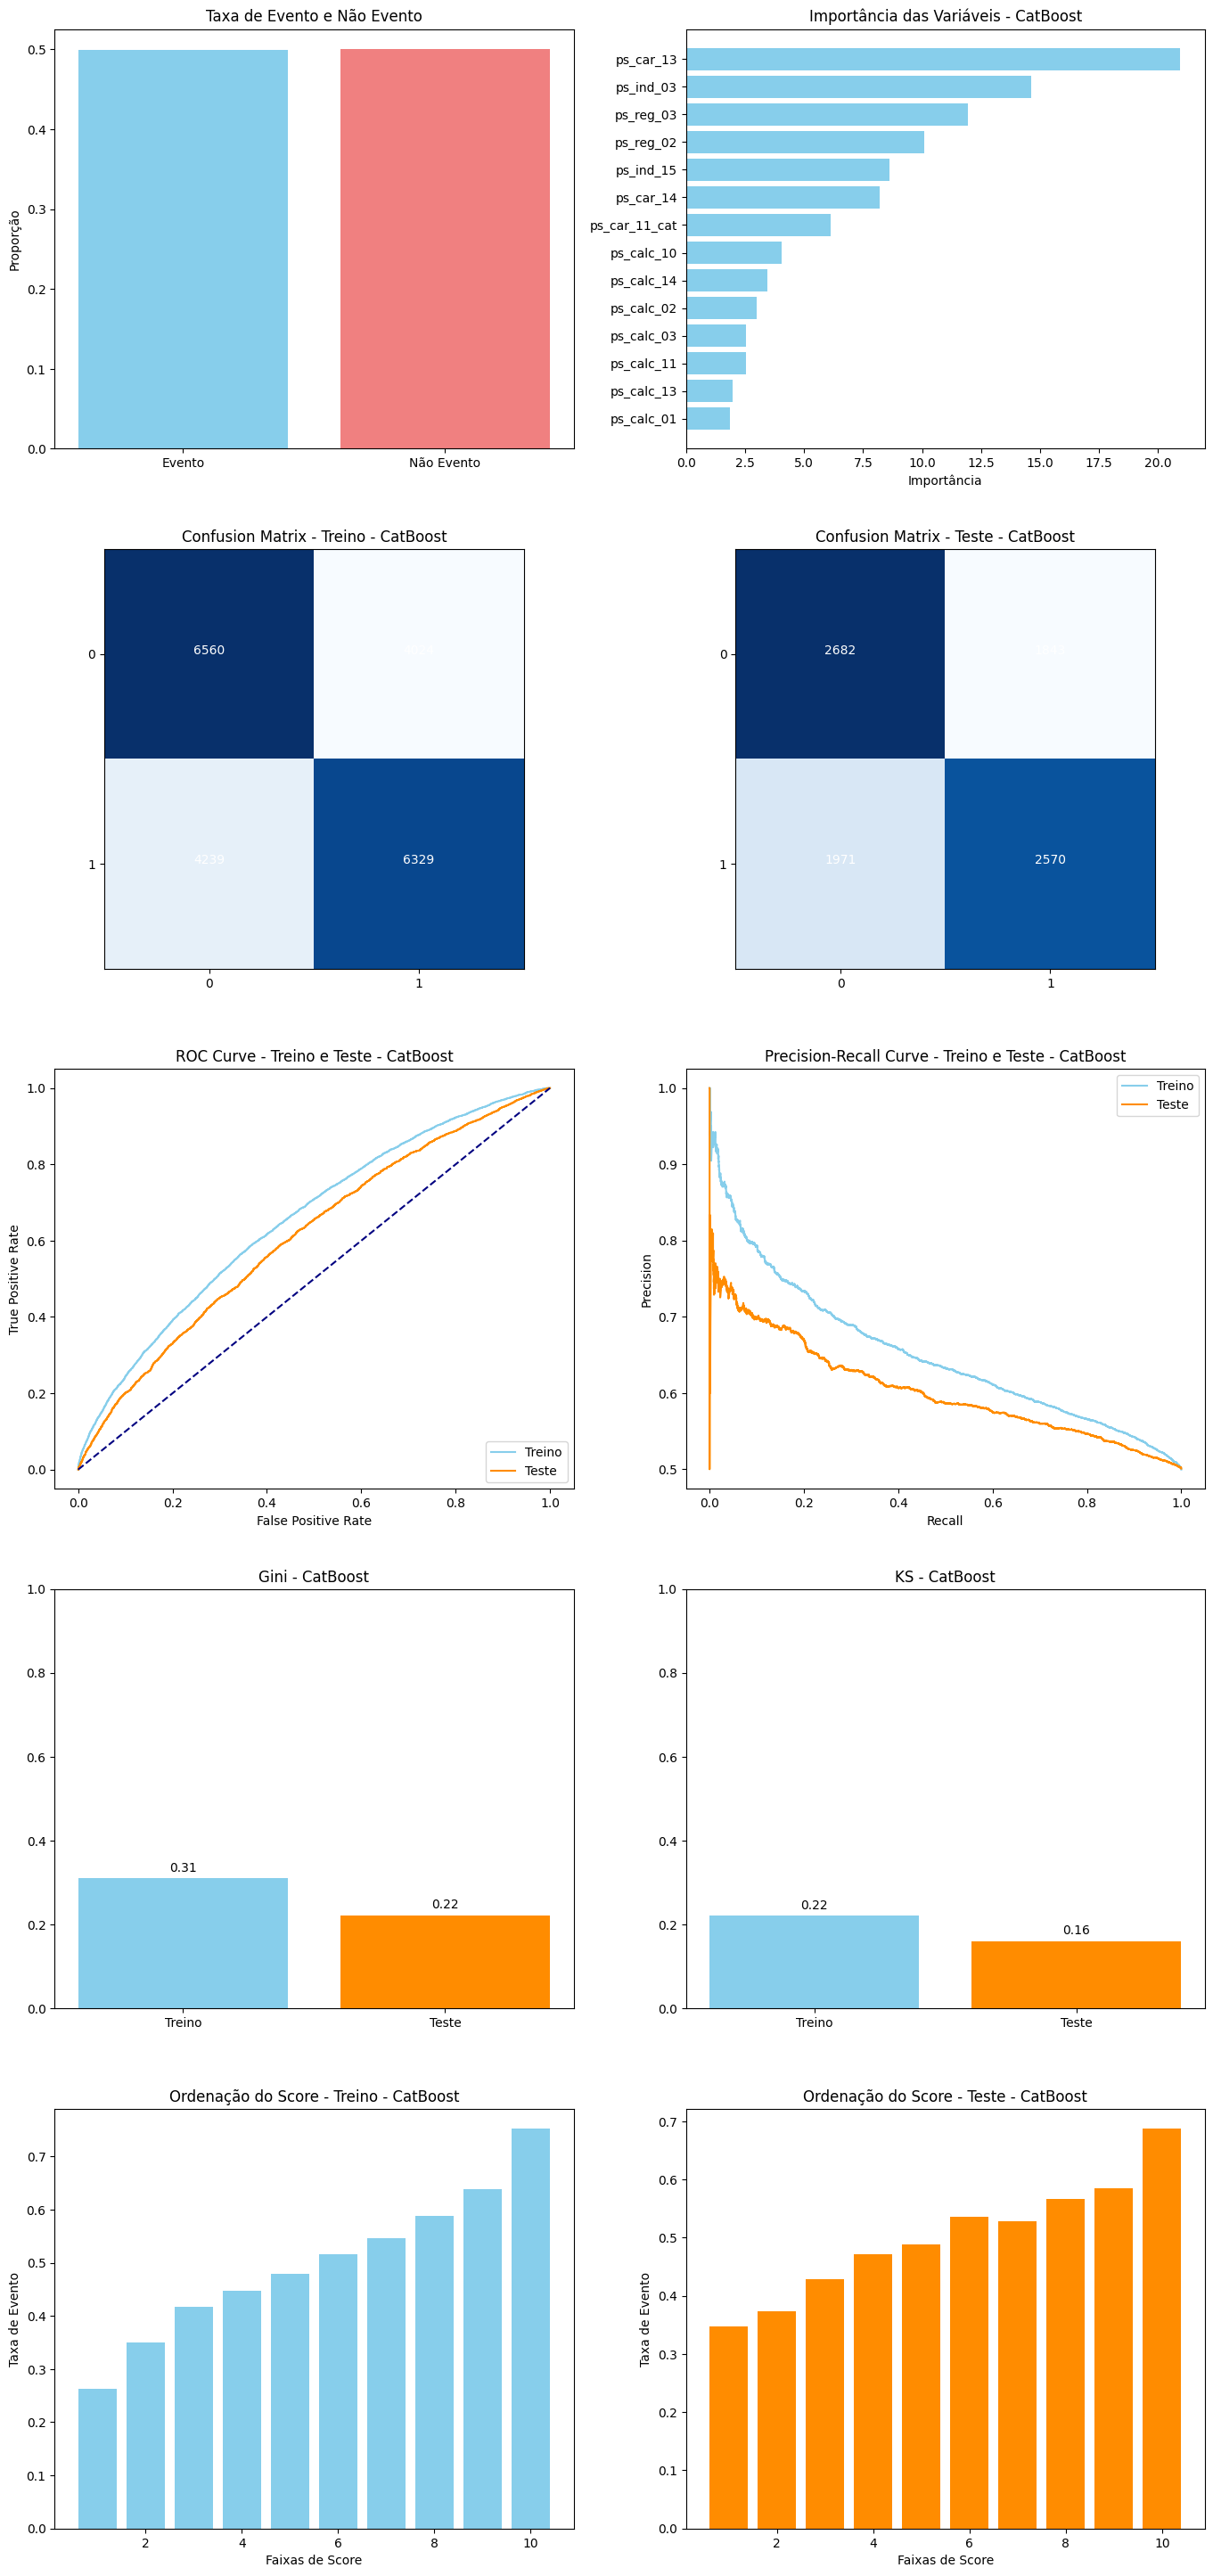

In [0]:
avaliar_modelo(X_train_cb, y_train, X_test_cb, y_test, best_model_cat, nm_modelo='CatBoost')

## Resultado

In [0]:
import pandas as pd
import pickle

# Resultados já obtidos (substitua pelos valores reais)
resultados = {
    'Modelo': ['Logistic Regression','Random Forest', 'XGBoost', 'LightGBM', 'CatBoost'],
    'AUC': [grid_rl.best_score_, grid_FDC.best_score_, grid_XGB.best_score_, grid_LGB.best_score_,grid_cat.best_score_],
    'Gini Normalizado': [gini_rl, gini_RF, gini_XGB, gini_LGBM,gini_test  ]
}

# Criando DataFrame
df_resultados = pd.DataFrame(resultados)

# Encontrando o melhor modelo pelo AUC
melhor_gini = df_resultados.loc[df_resultados['Gini Normalizado'].idxmax()]


print("=== Comparação dos Modelos ===")
print(df_resultados)

print("\n✅ Modelo que se destacou pelo Gini:")
print(f"Modelo: {melhor_gini['Modelo']}")
print(f"AUC: {melhor_gini['AUC']}")
print(f"Gini Normalizado: {melhor_gini['Gini Normalizado']}")


=== Comparação dos Modelos ===
                Modelo       AUC  Gini Normalizado
0  Logistic Regression  0.599148          0.183000
1        Random Forest  0.606176          0.200000
2              XGBoost  0.609939          0.220000
3             LightGBM  0.608759          0.210000
4             CatBoost  0.614352          0.221829

✅ Modelo que se destacou pelo Gini:
Modelo: CatBoost
AUC: 0.6143524801703684
Gini Normalizado: 0.2218289592308751
